# **Úvod**
V úvode sme najprv potrebovali nainštalovať potrebné knižnice, aby sme mohli prekonvertovať súbory s dátami.

Príkaz "**%%capture**" bol použitý, aby sa zbytočne nevypisovali výstupy z inštalácie. Potrebujeme nainštalovať modul "**geopandas**", ktorý budeme používať pri práci s dátami.

In [ ]:
%%capture
!pip install geopandas
!pip install lxml

In [ ]:
import zipfile
import requests
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from wordcloud import WordCloud

import plotly.express as px

# **Spracovanie raw dát**
Spracovaniu dát sme sa venovali v inom notebooku ([link na notebook](https://colab.research.google.com/drive/1-eXGAYIZ7dQKMLUlwWH95qu_SySDV5ht#scrollTo=0beb5c1c-cd83-4397-913a-35ab6db1fd4a)), kde je všetko popísané. Nechceli sme všetky bunky dávať sem, pretože niektoré procesy trvali približne 2 minúty.


# **Načítanie dát**
Dáta načítavame z nášho exportu v externom notebooku.

In [ ]:
url = 'https://github.com/erikbozik/Earthquakes/raw/main/hazards_geojson.zip'

data = requests.get(url)

with zipfile.ZipFile(io.BytesIO(data.content)) as zip_ref:
    with zip_ref.open('hazards_geojson/earthquakes.geojson', 'r') as file:
        earthquakes = gpd.read_file(file)
    with zip_ref.open('hazards_geojson/volEvents.geojson', 'r') as file:
        volEvents = gpd.read_file(file)
    with zip_ref.open('hazards_geojson/tsunamiEvents.geojson', 'r') as file:
        tsunamiEvents = gpd.read_file(file)
    with zip_ref.open('hazards_geojson/tsunami_runups.geojson', 'r') as file:
        tsunami_runups = gpd.read_file(file)
    print('succesfully loaded all data')

succesfully loaded all data


# **Analýza**

## **1. Otázka: Závislosť magnitúdy zemetrasení a úmrtí**

In [ ]:
# Convert GeoJSON to CSV
earthquakes.to_csv('earthquakes.csv', index=False)
volEvents.to_csv('volEvents.csv', index=False)
tsunamiEvents.to_csv('tsunamiEvents.csv', index=False)
tsunami_runups.to_csv('tsunami_runups.csv', index=False)

from google.colab import files

# Download CSV files
files.download('earthquakes.csv')
files.download('volEvents.csv')
files.download('tsunamiEvents.csv')
files.download('tsunami_runups.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Magnitúda a úmrtia**
V nasledujúcich blokoch porovnáme úmrtia a magnitúdu zemetrasení. Zemetrasenia, pri ktorých nemáme údaje o počtu úmrtí a magnitúde zanedbávame.

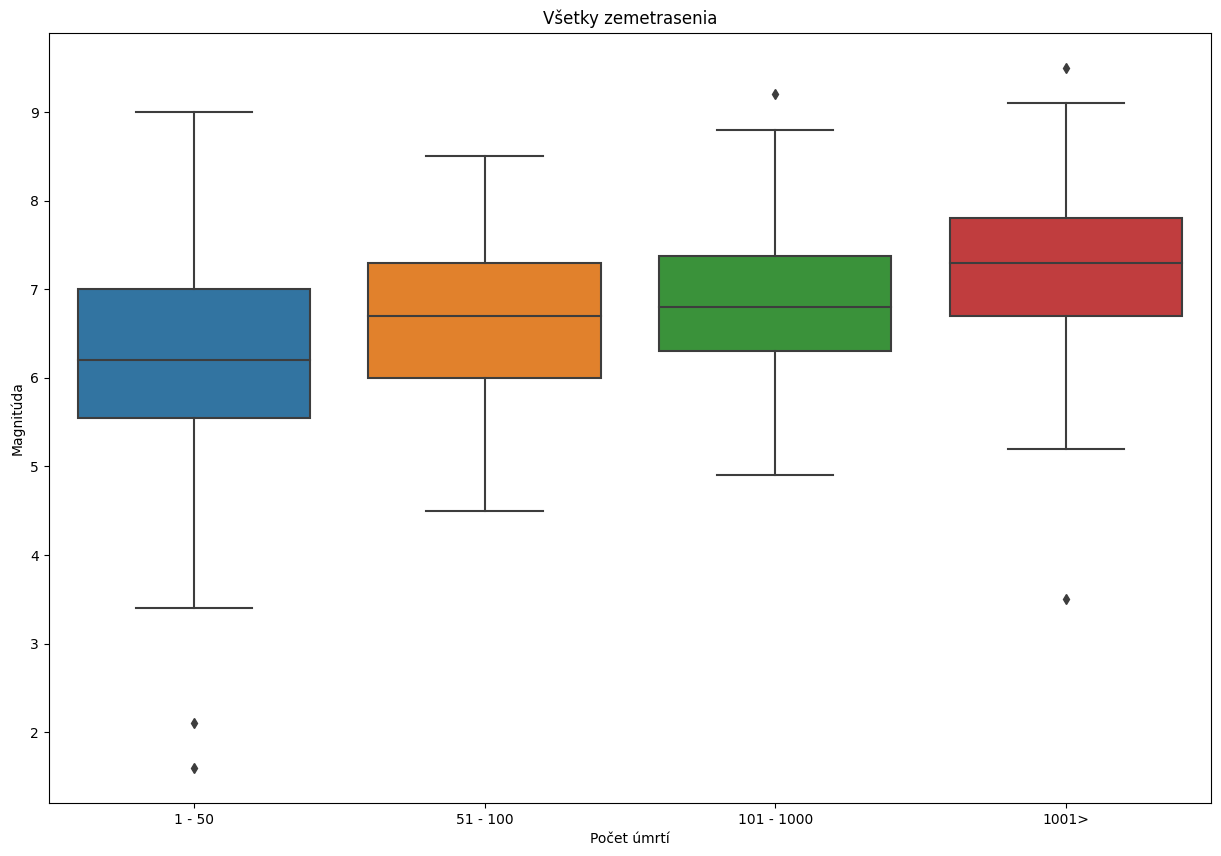

In [ ]:
earthquakes1 = earthquakes.copy(deep=True).query("`magnitude`.notnull() and `deaths`.notnull()")
def deaths_parse(value):
    if value is not np.nan:
        index = value.find('(')
        key, value = value[: index].strip(), value[index + 2:]
        ran = ()
        for i in value.split():
             try:
                 ran += int(i),
             except ValueError:
                 pass
        if len(ran) != 2:
            out = (ran[0], '>')
        else:
            out = (ran[0], ran[1])
        return out
    return value


earthquakes1['deaths'] = earthquakes1['deaths'].apply(deaths_parse)
earthquakes1['magnitude'] = earthquakes1['magnitude'].astype(float)
earthquakes1 = earthquakes1.sort_values(by='deaths')
earthquakes1['deaths'] = earthquakes1['deaths'].apply(lambda x: f'{x[0]} - {x[1]}' if x[1] != '>' else f'{x[0]}>')

figure, axes = plt.subplots(figsize=(15, 10))
e_death_scatter = sns.boxplot(data=earthquakes1, x='deaths', y='magnitude')
e_death_scatter.set_ylabel('Magnitúda')
e_death_scatter.set_xlabel('Počet úmrtí')
e_death_scatter.set_title('Všetky zemetrasenia')
pass

V tomto grafe môžeme vidieť závislosť smrtí spôsobenými zemetraseniami a výškou magnitúdy teda sily zemetrasenia.

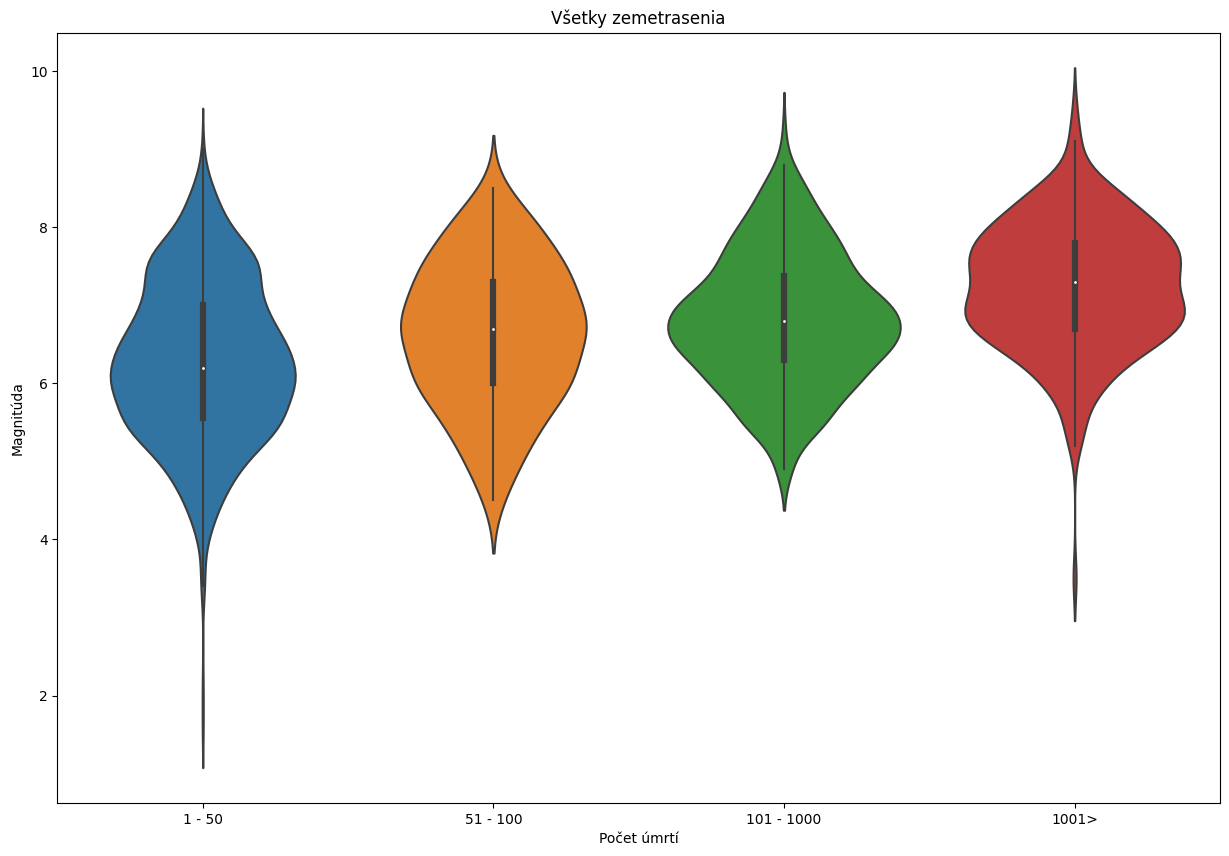

In [ ]:
figure, axes = plt.subplots(figsize=(15, 10))
earthquakes1['magnitude'] = earthquakes1['magnitude'].astype(float)


e_death_violin = sns.violinplot(data=earthquakes1, x='deaths', y='magnitude')

low_deaths_max_mag = earthquakes1.query("`deaths` == '1 - 50'")['magnitude'].max()
e_death_violin.set_title('Všetky zemetrasenia')
e_death_violin.set_ylabel('Magnitúda')
e_death_violin.set_xlabel('Počet úmrtí')
pass

V tomto grafe môžeme vidieť závislosť smrtí spôsobenými zemetraseniami a výškou magnitúdy teda sily zemetrasenia.




### **Mapa nízkej úmrtnosti a nízkej hustoty obyvateľstva po roku 1950**
Vidíme, ako sa magnitúda schodovito vyvíja. Zaujal nás ďalej úsek zemetrasení s malým počtom úmrtí ale vysokou magnitúdou. Domnievame sa, že vysoká magnitúda spôsobila málo úmrtí, pretože poloha epicentra daného zemetrasenia bola v miestach kde je málo ľudí. Ako tak vidíme, že veľa z týchto zemetrasení sa nachádza ďalej od pobrežia alebo úplne v oceánoch. Z údajov o hustote obyvateľstva vidíme, že takéto zemetrasenia sa skôr diali v krajinách z nižšou hustotou. Keďže máme dáta o hustote relevantné tak na posledných 50 rokov tak pre väčšiu presnosť porovnáme len zemetrasenia, ktoré sa udiali len od roku 1950. Veľká magnitúda, málo úmrtí zobrazené na mape v korelácií s hustotou obyvateľstva od roku 1950.


In [ ]:
# countries data
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_areas = countries['geometry'].to_crs({'proj':'cea'}).area  / 1e6
countries['area'] = country_areas
density = (countries['pop_est']
           / countries['area'])
countries['pop_dens'] = density
display(countries.head())
pass

<ipython-input-6-ab3967e441f6>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry          area   pop_dens  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  1.928760e+04  46.141190  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  9.327793e+05  62.185621  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  9.666925e+04   6.240382  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  1.003773e+07   3.744797  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  9.509851e+06  34.515738

In [ ]:
high_magnitude_low_deaths = earthquakes1.copy(deep=True).query("`magnitude` > 7.5 and `deaths` == '1 - 50' and year > 1950")

main = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color='pop_dens',
    color_continuous_scale='Blues',
    range_color=(0, 250),
    projection='mollweide',
    title='Mapa nízkej úmrtnosti a nízkej hustoty obyvateľstva po roku 1950'
)
fig = px.scatter_geo(
    high_magnitude_low_deaths,
    lat=high_magnitude_low_deaths.geometry.y,
    lon=high_magnitude_low_deaths.geometry.x,
    hover_name="location",
    hover_data=['magnitude', 'deaths', 'tsunami', 'date'],
    color_discrete_sequence=['#cb0000'],
    projection="mollweide"
    )
main.add_trace(fig.data[0])
main.update_layout(width=1800, height=1000)
main.show()

Môžeme vidieť, že tieto zemetrasenia sa diali v krajinách s nízkou hustotou zaľudnenia. Domnievame sa teda, že ak sa zemetrasenie udeje v niektorej z krajín s nízkou hustotou obyvateľstva (napríklad v miestach mimo miest), tak sa následne takéto zemetrasenia neprejaví vysokou úmrtnosťou. V miestach blízko krajín s vysokou zaľudnenosťou pozorujeme epicentrá (až na pár výnimiek) na pobrežiach až ďalej, v moriach a oceánoch.

### **Mapa nízkej úmrtnosti v kombinácii s mestami po roku 1950**

In [1]:
url_cities = 'https://github.com/erikbozik/Earthquakes/raw/main/worldcities.csv'
cities = pd.read_csv(url_cities)

NameError: name 'pd' is not defined

In [ ]:
e_cop = earthquakes.copy(deep=True).query("`deaths`.notnull()")
e_cop['deaths'] = e_cop['deaths'].apply(deaths_parse)
e_cop.magnitude = e_cop.magnitude.astype(float)
e_cop['deaths'] = e_cop['deaths'].apply(lambda x: f'{x[0]} - {x[1]}' if x[1] != '>' else f'{x[0]}>')

main = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color_discrete_sequence=['#ffffff'],
    projection='mollweide',
    title='Mapa nízkej úmrtnosti v kombinácii s mestami po roku 1950'
)

cities_to_scatter = cities.copy(deep=True).query("`population` > 50000")
towns = px.scatter_geo(
    cities_to_scatter,
    lat=cities_to_scatter.lat,
    lon=cities_to_scatter.lng,
    hover_name='city',
    hover_data=['country', 'population'],
    projection='mollweide'
)

deaths_earthquakes = e_cop.copy(deep=True).query("`magnitude` > 7.5 and `deaths` == '1 - 50' and year > 1950")
deaths = px.scatter_geo(
    deaths_earthquakes,
    lat=deaths_earthquakes.geometry.y,
    lon=deaths_earthquakes.geometry.x,
    hover_name='date',
    hover_data=['deaths'],
    color_discrete_sequence=['#cb0000'],
    size='magnitude',
    projection='mollweide'
)

main.add_trace(towns.data[0])
main.add_trace(deaths.data[0])
main.update_layout(width=1800, height=1000, geo = dict(showlakes=False))
main.show()

Na mape môžeme vidieť mestá ktoré majú počet obyvateľov väčší ako 5000 znázornené modrými bodmi a zemetrasenia s magnitúdou vyššou ako 7.5 a s nízkou úmrtnosťou od roku 1950 znázornené väčšími červenými bodmi.

### **Mapa vysokej úmrtnosti a vysokej hustoty obyvateľstva po roku 1950**

In [ ]:
e_high_deaths = earthquakes1.query("`deaths` == '1001>' and `year` > 1950")

main = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color='pop_dens',
    color_continuous_scale='Blues',
    range_color=(0, 250),
    projection='mollweide',
    title='Mapa vysokej úmrtnosti a vysokej hustoty obyvateľstva po roku 1950'
)
fig = px.scatter_geo(
    e_high_deaths,
    lat=e_high_deaths.geometry.y,
    lon=e_high_deaths.geometry.x,
    hover_name="location",
    hover_data=['magnitude', 'deaths', 'tsunami', 'date'],
    color_discrete_sequence=['#cb0000'],
    projection="mollweide"
    )
main.add_trace(fig.data[0])
main.update_layout(width=1800, height=1000)
main.show()

Na mape môžeme vidieť znázornenú hustotu jednotlivých štátov podľa sýtosti modrej farby a zemetrasenia s vysokou úmrtnosťou zobrazené červenými bodmi.

### **Mapa vysokej úmrtnosti v kombinácii s mestami po roku 1950**
Porovnáme ešte tieto zemetrasenia so všetkými takými, ktoré vyvolali vysokú úmrtnosť. Pri týchto môžeme práve pozorovať epicentrá vo vnútrozemiach krajín s vyššou hustotou zaľudnenia. Nepozorujeme žiadne, ktoré by sa objavilo v oceáne alebo ďaleko od pevniny. Pár epicentier však pozorujeme rovnakých ako pri zemetraseniach s vysokou magnitúdou ale malou úmrtnosťou. Pri týchto sa domnievame, že sa jednalo o iné vplyvy, ktoré tento jav spôsobili.

In [ ]:
main = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color_discrete_sequence=['#ffffff'],
    projection='mollweide',
    title='Mapa vysokej úmrtnosti v kombinácii s mestami po roku 1950'
)

cities_to_scatter = cities.copy(deep=True).query("`population` > 50000")
towns = px.scatter_geo(
    cities_to_scatter,
    lat=cities_to_scatter.lat,
    lon=cities_to_scatter.lng,
    hover_name='city',
    hover_data=['country', 'population'],
    projection='mollweide'
)

deaths_earthquakes = e_cop.copy(deep=True).query("`deaths` == '1001>' and year > 1950")
deaths = px.scatter_geo(
    deaths_earthquakes,
    lat=deaths_earthquakes.geometry.y,
    lon=deaths_earthquakes.geometry.x,
    hover_name='date',
    hover_data=['deaths'],
    color_discrete_sequence=['#cb0000'],
    size='magnitude',
    projection='mollweide'
)

main.add_trace(towns.data[0])
main.add_trace(deaths.data[0])
main.update_layout(width=1800, height=1000, geo = dict(showlakes=False))
main.show()

Na mape môžeme vidieť mestá, ktoré majú počet obyvateľov väčší ako 50000 znázornené modrými bodmi a zemetrasenia s magnitúdou vyššou ako 7.5 a s vysokou úmrtnosťou od roku 1950 znázornené väčšími červenými bodmi.

## **2. Otázka: Kde a kedy sa zemetrasenia diali/dejú**

### **Počet zemetrasení v jednotlivých štátoch**
V tejto časti skúmame, v ktorých štátoch sa deje najviac zemetrasení.

In [ ]:
most_e = earthquakes.copy(deep=True)
most_e['location'] = most_e['location'].astype(str)
def country(value):
    index = value.find(':')
    if index != -1:
        return value[: index]
    else:
        return value
most_e['source_country'] = most_e['location'].apply(country)
display(most_e)

location magnitude                      deaths  \
0         JORDAN: BAB-A-DARAA,AL-KARAK       7.3                         NaN   
1                      TURKMENISTAN: W       7.1       Few (~1 to 50 people)   
2                        SYRIA: UGARIT       NaN  Many (~101 to 1000 people)   
3     GREECE: THERA ISLAND (SANTORINI)       NaN  Many (~101 to 1000 people)   
4              ISRAEL: ARIHA (JERICHO)       NaN                         NaN   
...                                ...       ...                         ...   
5879                             CHILE       7.6                         NaN   
5880                      FIJI ISLANDS       6.9                         NaN   
5881                     INDIA: AMBASA       5.5       Few (~1 to 50 people)   
5882                       IRAN: KHONJ       5.3       Few (~1 to 50 people)   
5883                  ITALY: FARINDOLA       5.7       Few (~1 to 50 people)   

     tsunami         date  year                     geometry source_country  
0          0  -2150/??/?? -2150    POINT (35.50000 31.10000)         JORDAN  
1          0  -2000/??/?? -2000    POINT (58.20000 38.00000)   TURKMENISTAN  
2          1  -2000/??/?? -2000    POINT (35.80000 35.68300)          SYRIA  
3          1  -1610/??/?? -1610    POINT (25.40000 36.40000)         GREECE  
4          0  -1566/??/?? -1566    POINT (35.30000 31.50000)         ISRAEL  
...      ...          ...   ...                          ...            ...  
5879       1   2016/12/25  2016  POINT (-73.88000 -43.41600)          CHILE  
5880       1   2017/01/03  2017  POINT (176.05300 -19.32600)   FIJI ISLANDS  
5881       0   2017/01/03  2017    POINT (92.00600 24.01600)          INDIA  
5882       0   2017/01/06  2017    POINT (53.11600 28.20500)           IRAN  
5883       0   2017/01/18  2017    POINT (13.24100 42.60100)          ITALY  

[5884 rows x 8 columns]

In [ ]:
counts_all_time = pd.DataFrame(most_e['source_country'].value_counts())
try:
  counts_all_time = counts_all_time.query('`count` > 23')
except:
  counts_all_time = counts_all_time.query('`source_country` > 23')
display(counts_all_time.shape)

(37, 1)

Hodnoty môžeme prehľadne pozorovať na barplote.

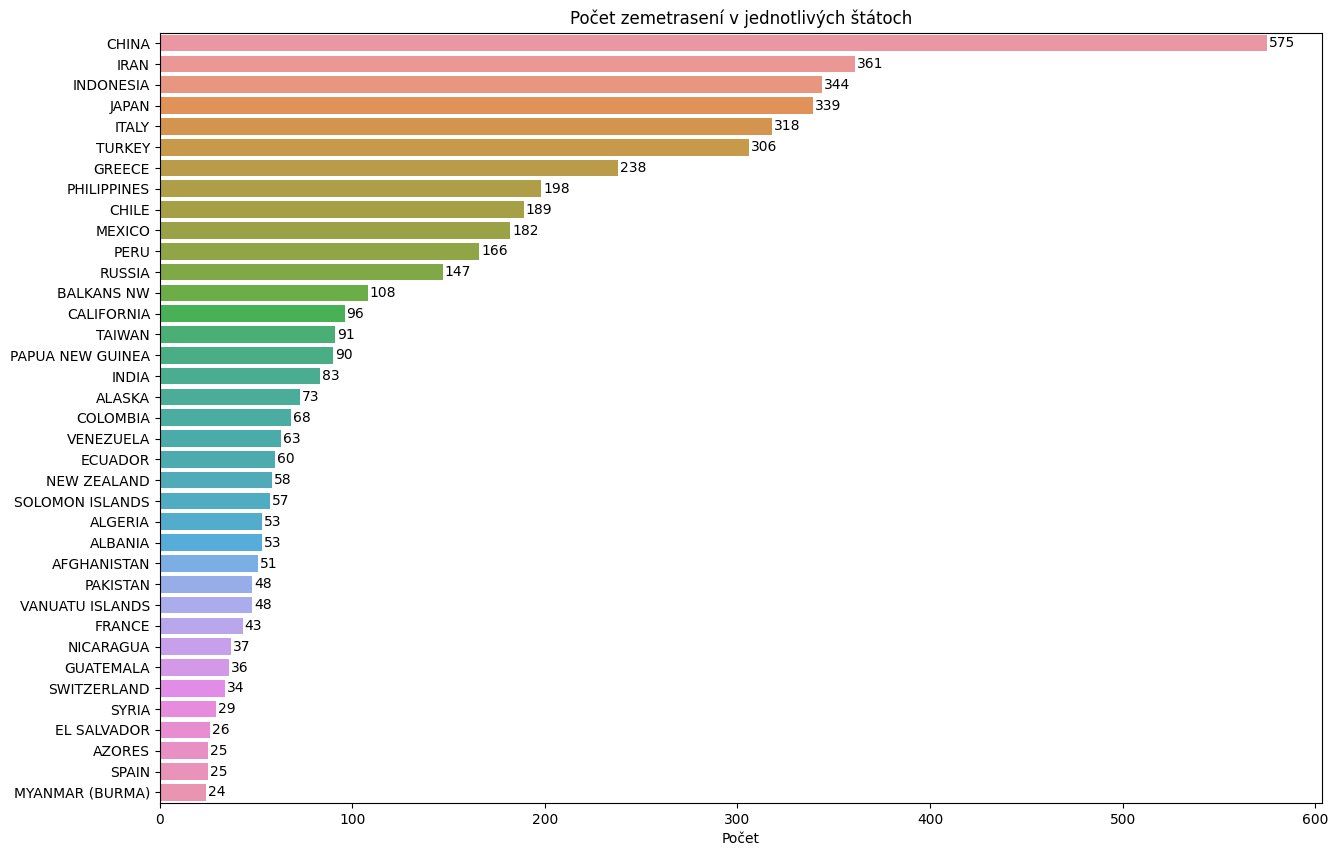

In [ ]:
try:
  axes = sns.barplot(data=counts_all_time, x='count', y=counts_all_time.index)
except:
  axes = sns.barplot(data=counts_all_time, x='source_country', y=counts_all_time.index)
axes.figure.set_size_inches(15,10)

height = 0
for i, rect in enumerate(axes.patches):
    try:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{counts_all_time["source_country"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1
    except KeyError:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{counts_all_time["count"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1
axes.set_xlabel('Počet')
axes.set_title('Počet zemetrasení v jednotlivých štátoch')
pass

Graf ukazuje počet všetkých zemetrasení v jednotlivých štách

### Počet zemetrasení od roku 1900





In [ ]:
counts_last_hundreds = most_e.query("`year` > 1900")
counts_last_hundreds = pd.DataFrame(counts_last_hundreds['source_country'].value_counts()) # value counts rovno zosortuje
try:
  counts_last_hundreds = counts_last_hundreds.query('`count` >= 16')
except:
  counts_last_hundreds = counts_last_hundreds.query('`source_country` >= 16')
display(counts_last_hundreds.shape)

(37, 1)

Znovu ukážeme dáta v barplote.

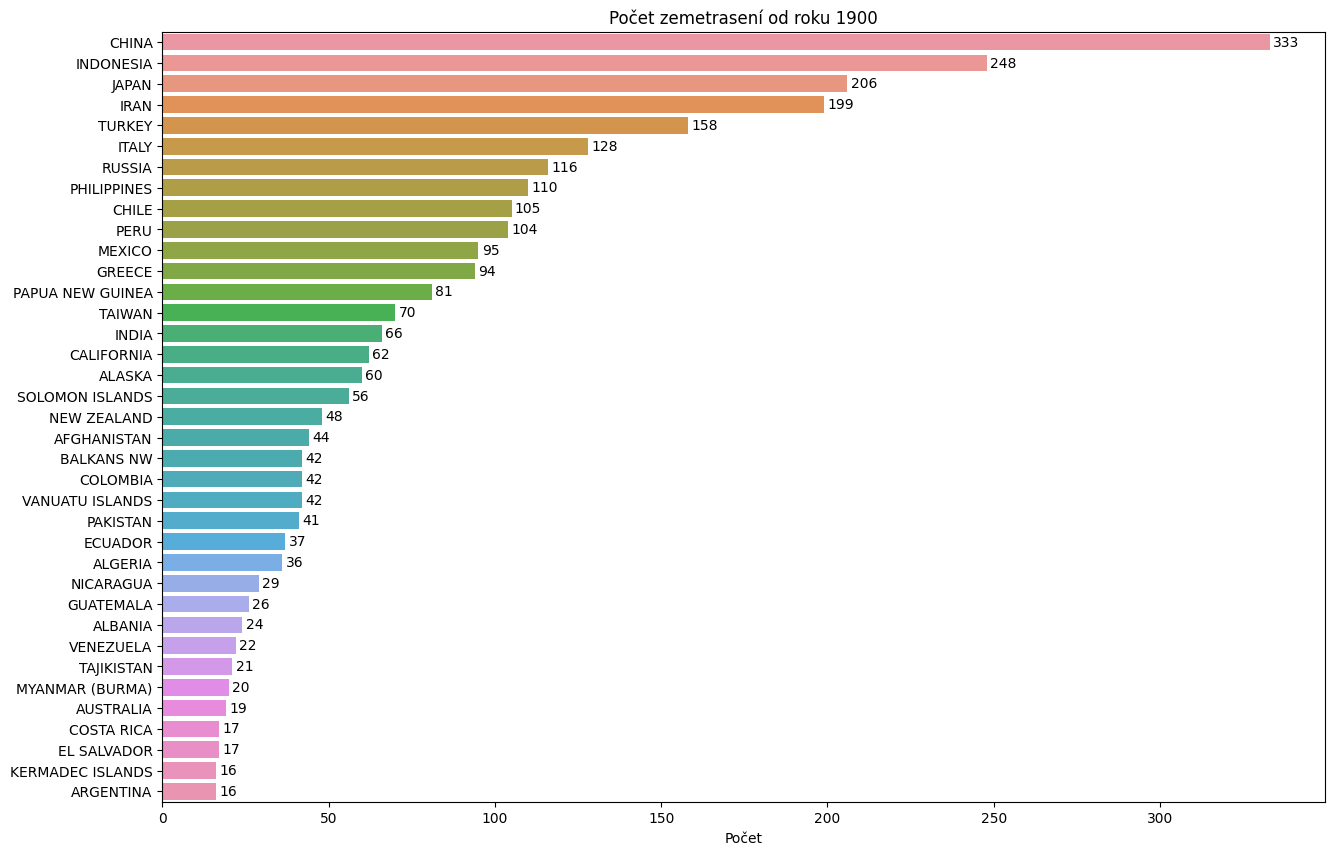

In [ ]:
try:
  axes = sns.barplot(data=counts_last_hundreds, x='count', y=counts_last_hundreds.index)
except:
  axes = sns.barplot(data=counts_last_hundreds, x='source_country', y=counts_last_hundreds.index)
axes.figure.set_size_inches(15,10)
height = 0
for i, rect in enumerate(axes.patches):
    try:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{counts_last_hundreds["source_country"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1
    except KeyError:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{counts_last_hundreds["count"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1
axes.set_xlabel('Počet')
axes.set_title('Počet zemetrasení od roku 1900')
pass

Graf ukazuje počet zemetrasení v jednotlivých štátoch od roku 1650

### **Distribúcia evidencie**
Môžeme vidieť, že evidencia sa s pribúdajúcimi sa rokmi zvyšuje. Pred rokom 1960 evidujeme nárast evidencie, ktorý sa držal na podobnej úrovni približne 3 desaťročia. Okolo roku 2000 sa zvýšila výrazne.

In [ ]:
e_magnitude_trends = most_e.copy(deep=True).query("`year` > 1900 and `magnitude`.notnull()")
# display(e_magnitude_trends)
e_magnitude_trends['date'] = e_magnitude_trends['date'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d', errors='coerce'))
e_magnitude_trends['magnitude'] = e_magnitude_trends['magnitude'].astype(float).apply(lambda x: round(x, 2))
magnitude_trends = counts_last_hundreds.copy(deep=True).iloc[0 : 10, :]
magnitude_trends = magnitude_trends.index

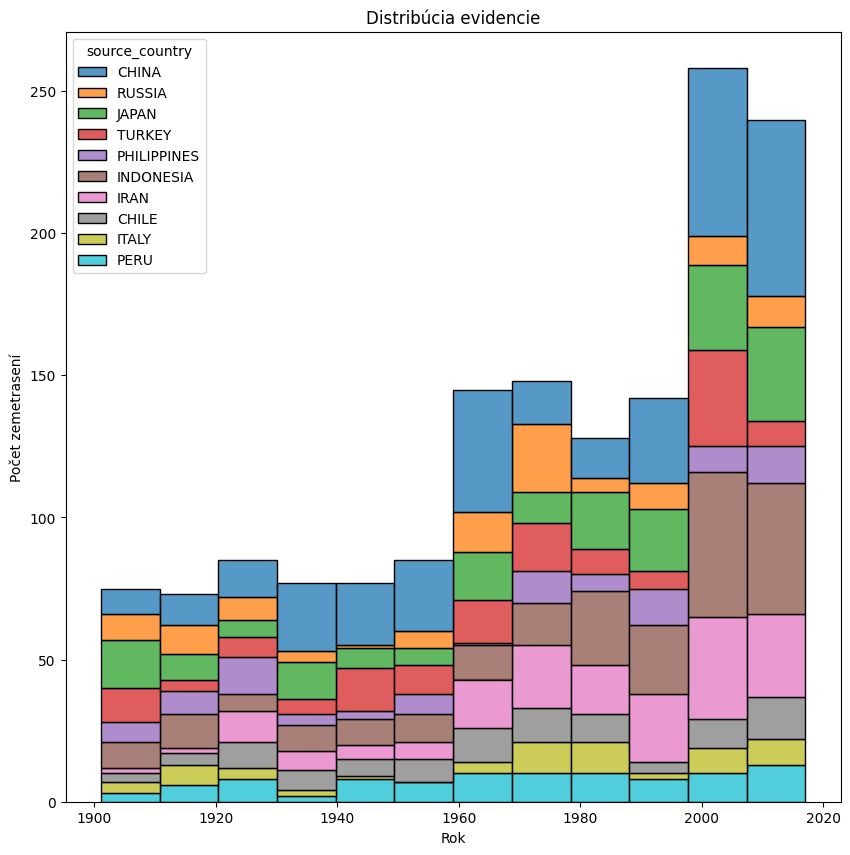

In [ ]:
figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=e_magnitude_trends.query("`source_country` in @magnitude_trends"), x='date', hue='source_country',
                  multiple='stack', bins=12)
ax.set_xlabel('Rok')
ax.set_ylabel('Počet zemetrasení')
ax.set_title('Distribúcia evidencie')
pass

Záver: Dôvody môžu byť viaceré. Buď sa jedná o to, že sa zvýšil počet zemetrasení od roku 1900. Toto si však nemyslíme. Skôr sa prikláname k alternatíve, že nastal posun v meracích metódach a vedeniu záznamov, ktorý viedol k tomu, že dokážeme zachytiť oveľa viac zemetrasení.

### **KDE evidencie**
Použijeme kde na to, aby sme vedeli zachytiť, ako sa v čase vyvíjal počet evidovaných zemetrasení.

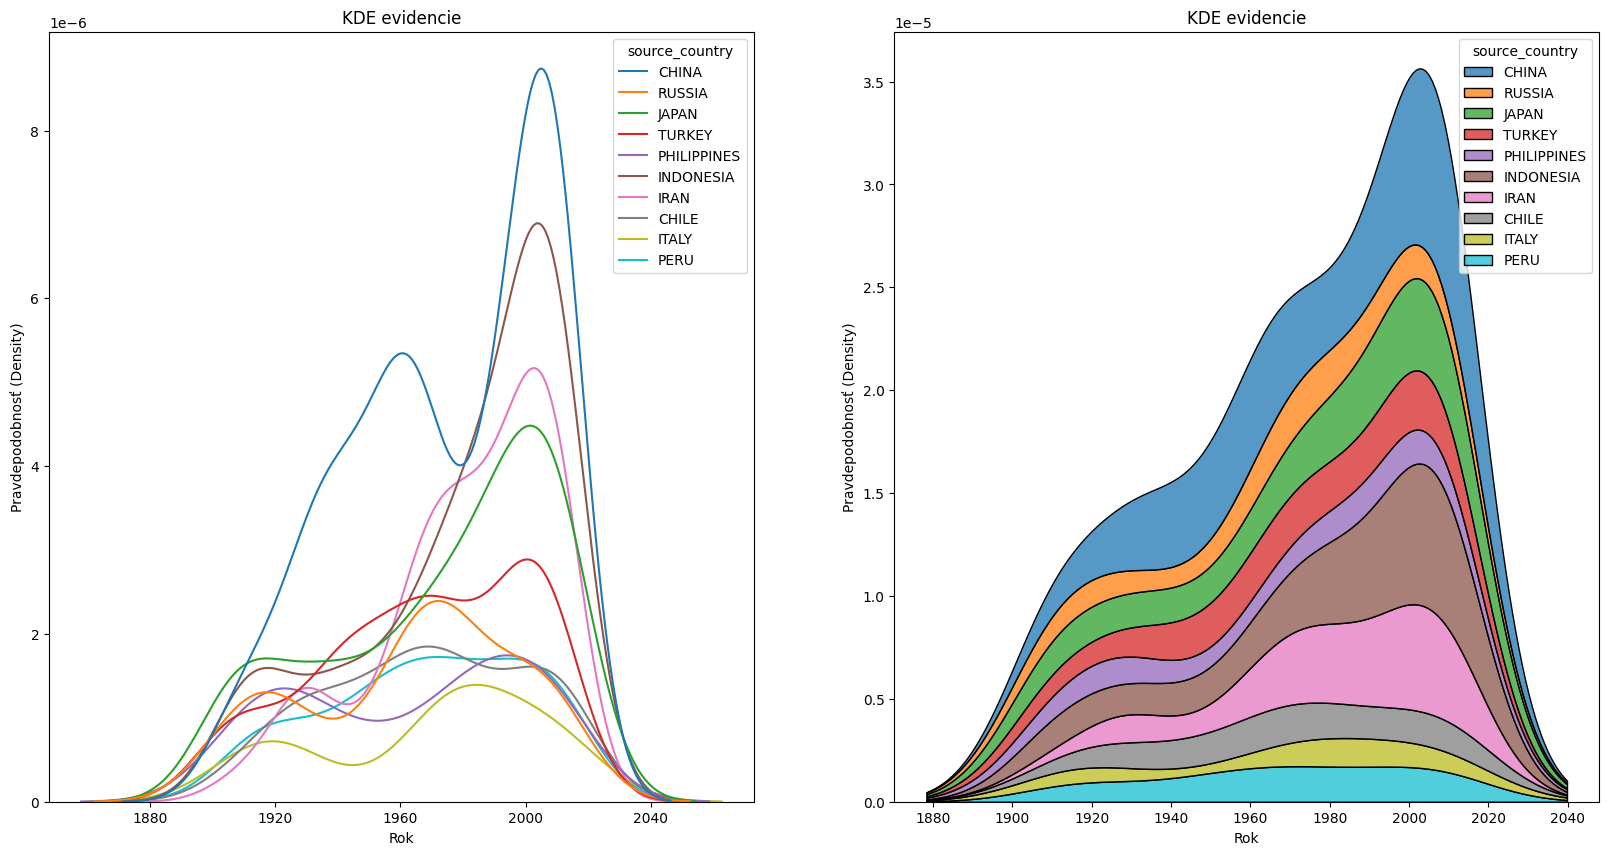

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(20, 10))
# print(len(axes))
ax = sns.kdeplot(data=e_magnitude_trends.query("`source_country` in @magnitude_trends"), x='date', hue='source_country', ax=axes[0])
# sns.kdeplot(data=e_magnitude_trends.query("`source_country` in @magnitude_trends"), x='date', hue='source_country', ax=axes[1])
ax.set_ylabel('Pravdepodobnosť (Density)')
# axes.axvline(x=pd.to_datetime('1940'), linestyle='--', color='black')
ax.set_xlabel('Rok')
ax.set_title('KDE evidencie')

ax = sns.kdeplot(data=e_magnitude_trends.query("`source_country` in @magnitude_trends"), x='date', hue='source_country', multiple='stack',
                 ax=axes[1])
ax.set_ylabel('Pravdepodobnosť (Density)')
ax.set_xlabel('Rok')
ax.set_title('KDE evidencie')
pass

Záver: Zistenia sú zaujímavé. Môžeme vnímať v jednotlivých štátoch určité zlomy(dipy), ktoré sa v určitých obdobiach objavovali. Jednalo sa o pokles zemetrasení v danej dobe? Môže byť. Avšak taktiež nemáme žiaden dôkaz toho, že evidenciu zemetrasení neovplyvnila žiadna situácia (politická, pandemická atď.). Obzvlášt podozrivý je pre nás však dip pri Rusku okolo roku 1940. Toto je zrovna obdobie 2. svetovej vojny. Podozrivý je taktiež dip v Číne okolo roku 1970, ktorý však nevieme ničím podložiť.

### **Mapa zemetrasenia vzhľadom na tektonické dosky**
Hodnoty si ukážeme aj na mape.

In [ ]:
url = 'https://github.com/erikbozik/Earthquakes/raw/main/PB2002_plates.json'
plates = gpd.read_file(url)

main = px.choropleth(
    plates,
    geojson=plates['geometry'],
    locations=plates.index,
    color=plates.index,
    color_continuous_scale='Brwnyl',
    projection='mollweide',
    title='Mapa zemetrasenia vzhľadom na tektonické dosky'
)
states = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color_discrete_sequence=['#ffffff'],
    projection='mollweide'
)

fig = px.scatter_geo(
    earthquakes,
    lat=earthquakes.geometry.y,
    lon=earthquakes.geometry.x,
    hover_name="location",
    hover_data=['magnitude', 'deaths', 'tsunami', 'date'],
    color_discrete_sequence=['#0043a5'],
    projection="mollweide"
)
main.add_trace(states.data[0])
main.add_trace(fig.data[0])
main.update_layout(width=1800, height=1000, coloraxis_showscale=False, geo = dict(showlakes=False))
main.show()

Na mape sú znázornené zemetrasenia modrými bodmi a hranice tektonických dosiek

### **TOP 10 krajín v počte zemetrasení v porovnaní s tektonickými doskami**



In [ ]:
countries_counts_index = counts_last_hundreds.iloc[0: 10, :].index
e_counts = most_e.query("`source_country` in @countries_counts_index")

countries_counts_index = countries_counts_index.str.lower()


fig = px.scatter_geo(
    e_counts,
    lat=e_counts.geometry.y,
    lon=e_counts.geometry.x,
    hover_name="location",
    hover_data=['magnitude', 'deaths', 'tsunami', 'date'],
    color_discrete_sequence=['#0043a5'],
    projection="mollweide"
)

countries2 = countries.copy(deep=True)
countries2['name'] = countries2['name'].str.lower()
countries2 = countries2.query("`name` in @countries_counts_index")


main = px.choropleth(
    plates,
    geojson=plates['geometry'],
    locations=plates.index,
    color=plates.index,
    color_continuous_scale='Brwnyl',
    projection='mollweide',
    title='TOP 10 krajín v počte zemetrasení v porovnaní s tektonickými doskami'
)

states = px.choropleth(
    countries2,
    locations=countries2['iso_a3'],
    color_discrete_sequence=['#ffffff'],
    projection='mollweide'
)

main.add_trace(fig.data[0])
main.add_trace(states.data[0])

main.update_layout(width=1800, height=1000, geo = dict(showlakes=False), coloraxis_showscale=False)
main.show()


Na mape sú znázornené zemetrasenia modrými bodmi v desiatich štátoch s najväčším počtom zemetrasení a hranice tektonických dosiek

### **Zastúpenie magnitúdy v TOP 10 krajinách**
V nasledujúcich grafoch zisťujeme v akom počte sa v top 10 krajinách od roku 1900 vyskytovali zemetrasenia s jednotlivými magnitúdami.

In [ ]:
def gen_xy(rows, cols):
    def gen_x(rows, cols):
        for i in range(rows):
            for j in range(cols):
                yield i

    def gen_y(rows, cols):
        for i in range(rows):
            for j in range(cols):
                yield j
    return list(gen_x(rows, cols)), list(gen_y(rows, cols))

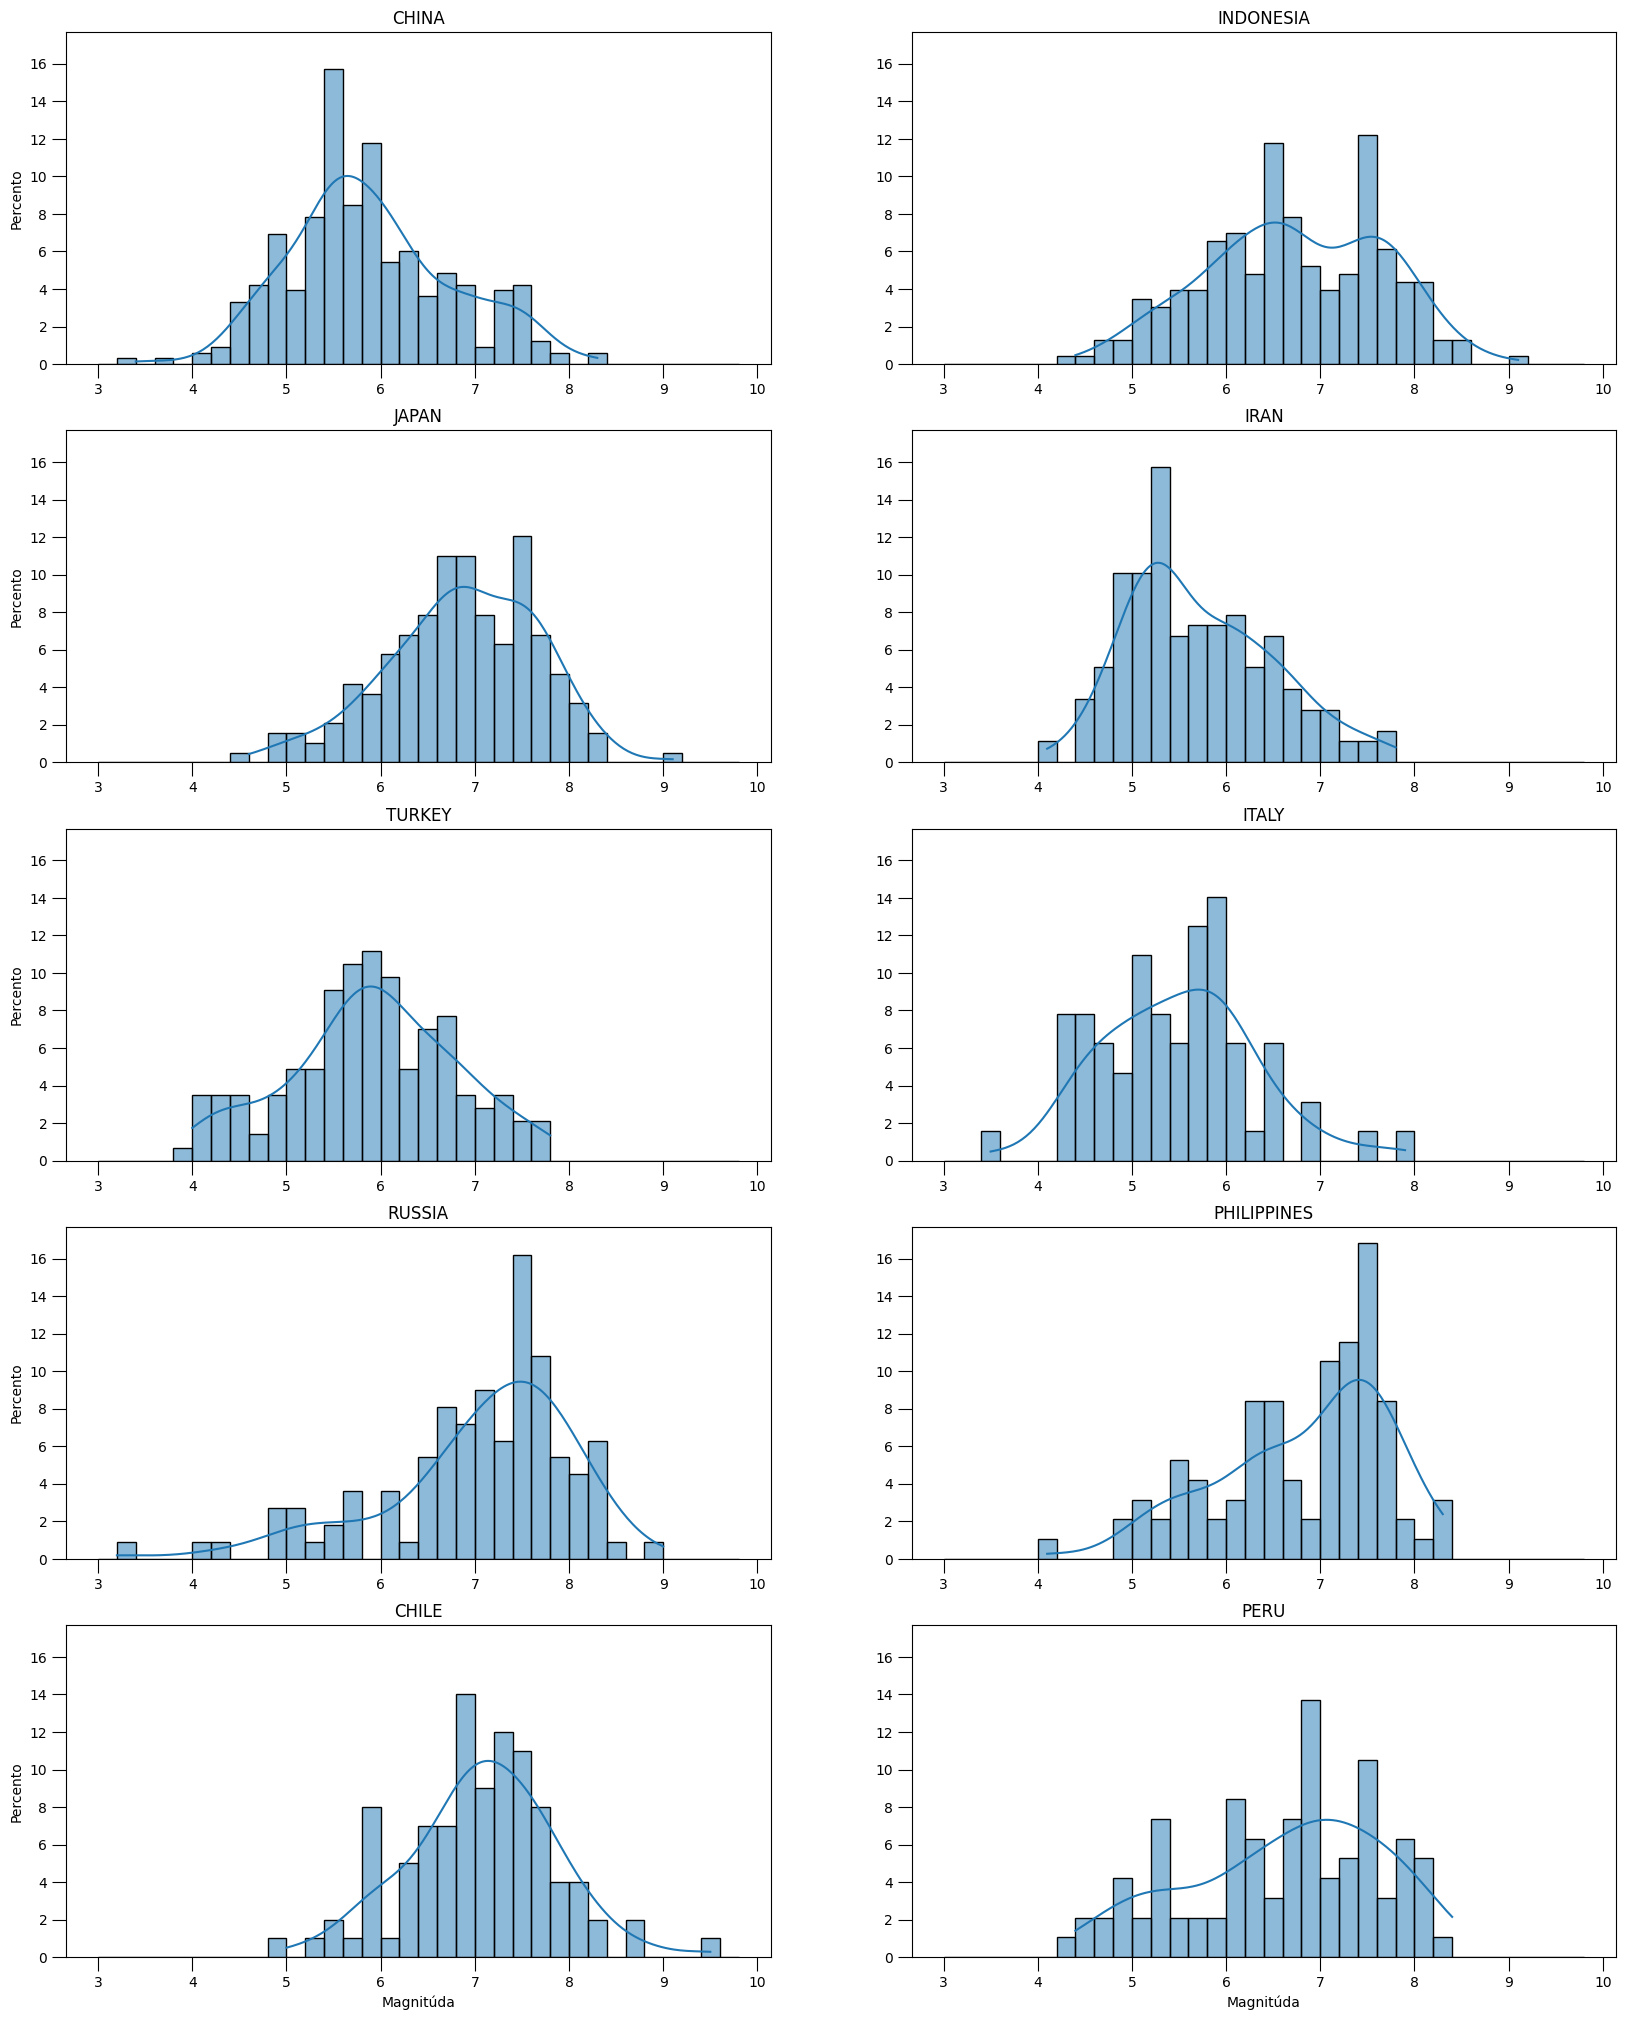

In [ ]:
grid = (5, 2)
figure, axes = plt.subplots(*grid, figsize=(20, 25), sharex=True, sharey=True)
# for itering rows, columns
x, y = gen_xy(*grid)
# print(x, y)
for order, i in enumerate(magnitude_trends):
    data = e_magnitude_trends.query("`source_country` == @i")
    ax = sns.histplot(data=data, x='magnitude', ax=axes[x[order], y[order]], kde=True, stat='percent', bins=np.arange(3, 10, 0.2))
    ax.set_title(i)
    ax.tick_params(axis='both', which='both', length=10)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_xlabel('Magnitúda')
    ax.set_ylabel('Percento')
# plt.tick_params()
pass

Záver: Vieme si všimnúť, že v jednotlivých štátoch majú magnitúdy zemetrasení rôzne zastúpenie. Určite teda vieme rozlíšiť, v ktorých štátoch sa dejú zemetrasenia vo väčšej magnitúde a v ktorých v menšej

### **Vývin magnitúdy v čase**
Ďalej sledujeme, vývin magnitúdy od roku 1900. Špeciálne pozorujeme, či prišlo k nejakému výraznemu nárastu/poklesu v priebehu rokov. Obzvlášť si všímame aj priemernú hodnotu magnitúdy.

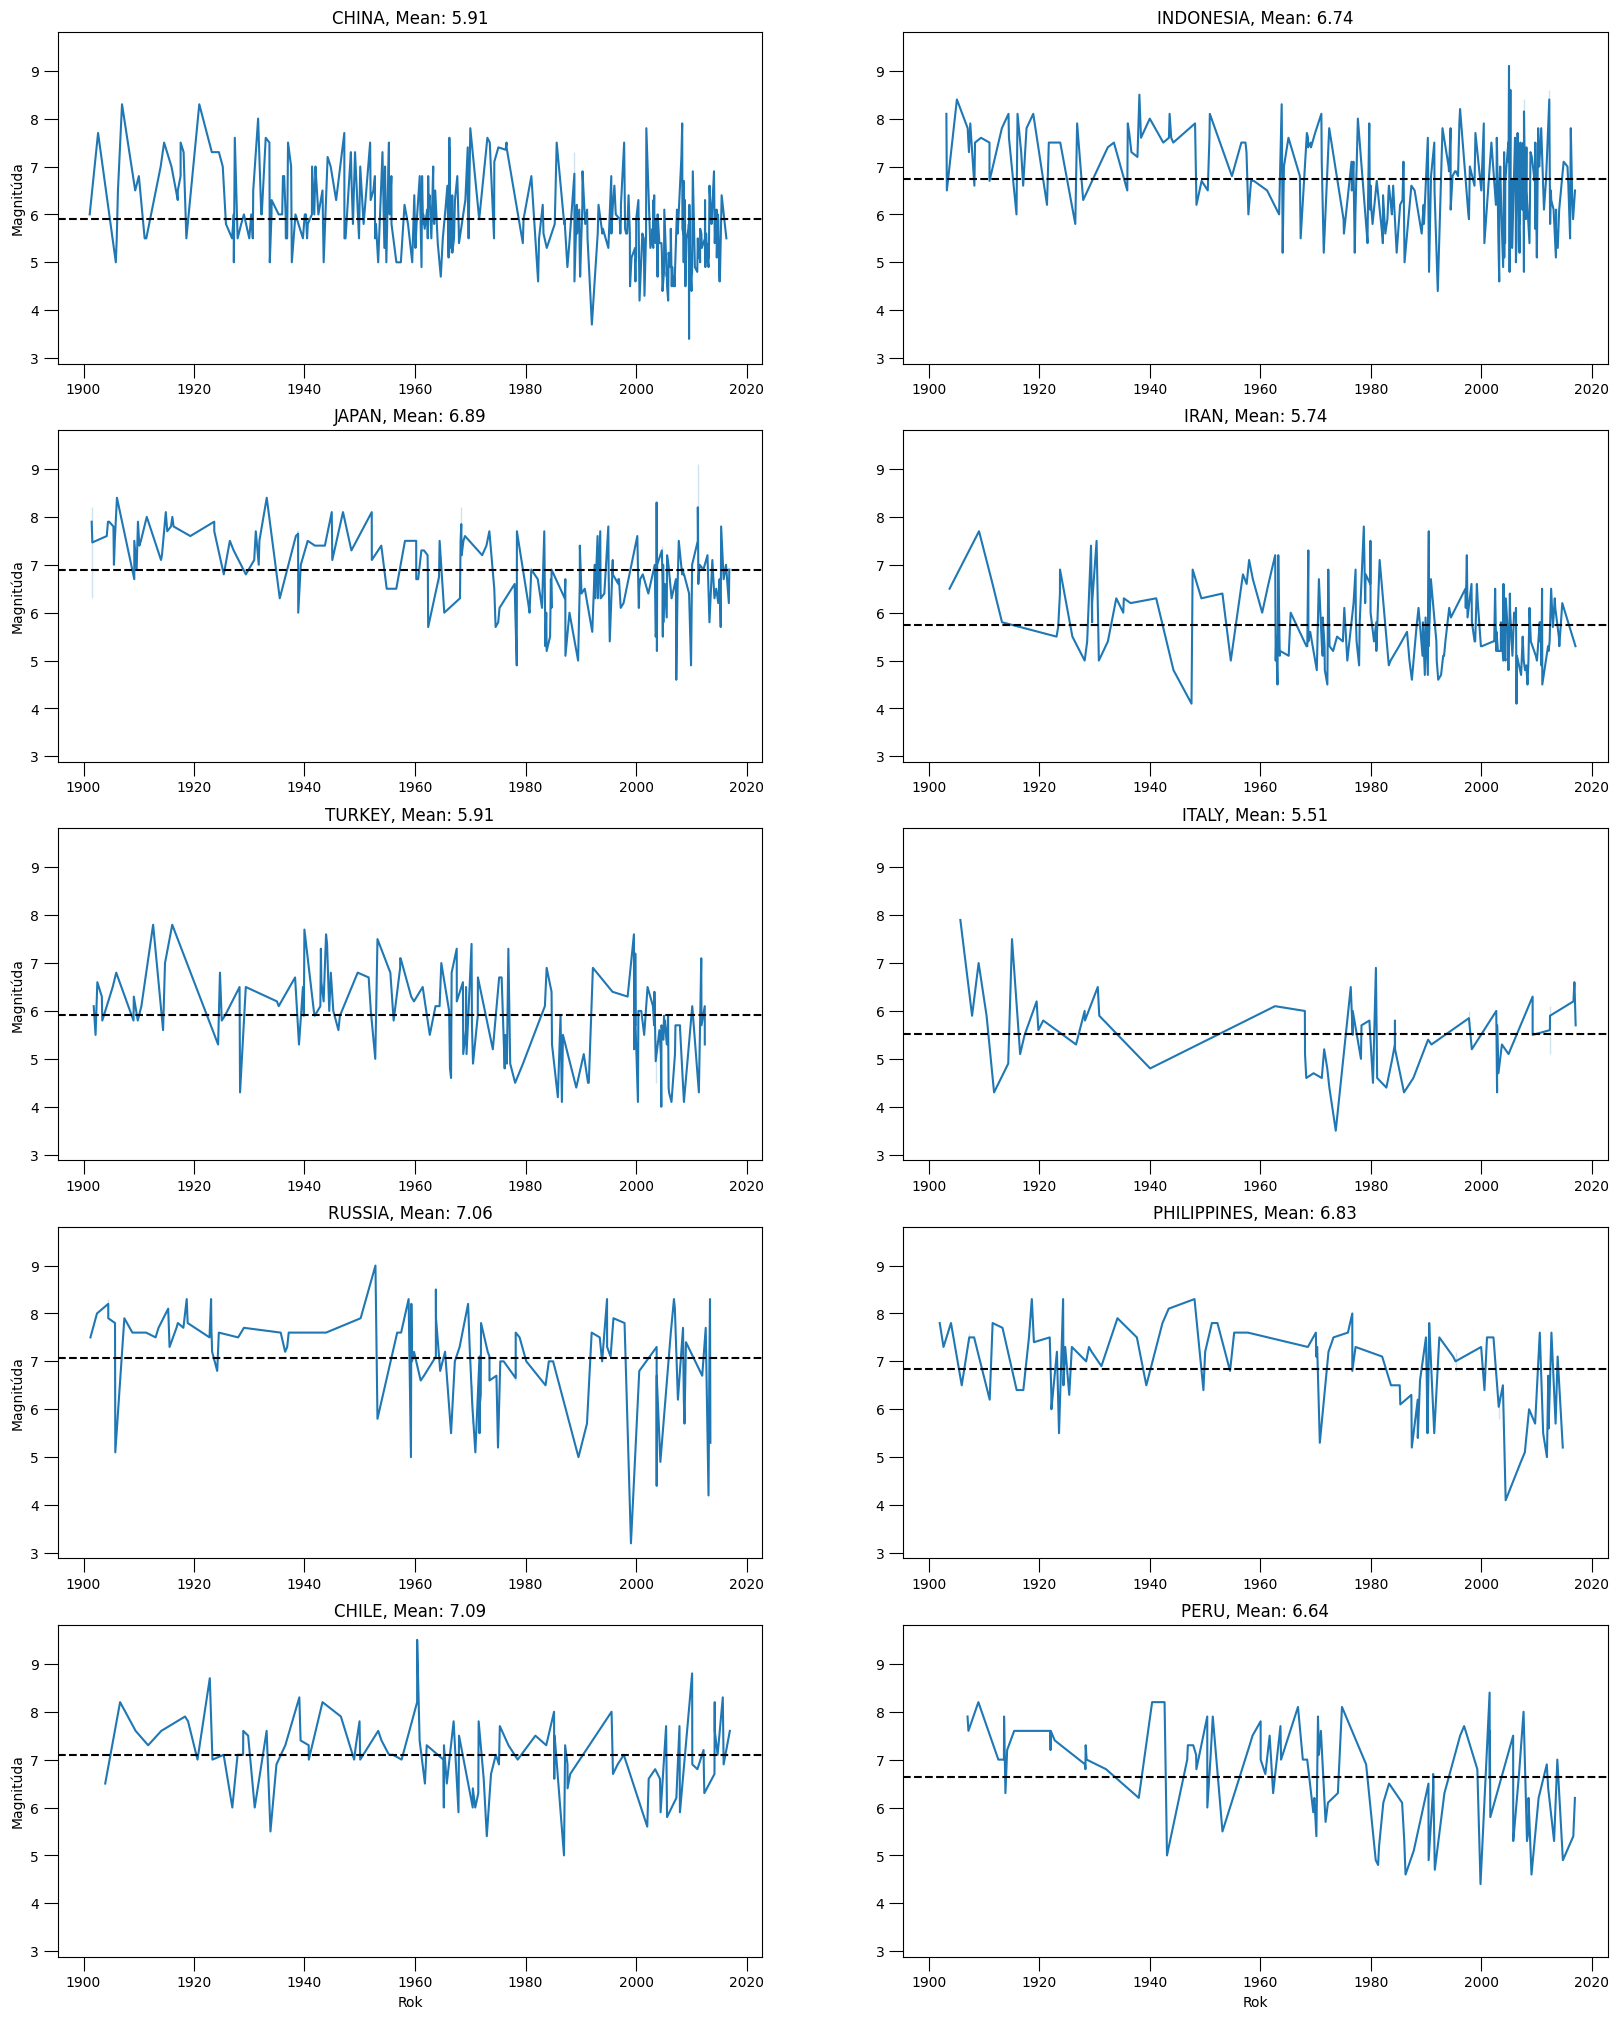

In [ ]:
figure, axes = plt.subplots(5, 2, figsize=(20, 25), sharex=True, sharey=True)

for order, i in enumerate(magnitude_trends):
    data = e_magnitude_trends.query("`source_country` == @i")
    ax = sns.lineplot(data=data, x='date', y='magnitude', ax=axes[x[order], y[order]])
    ax.tick_params(axis='both', which='both', length=10)
    ax.tick_params(labelbottom=True, labelleft=True)
    mean = data['magnitude'].mean()
    axes[x[order], y[order]].axhline(y=mean, color='black', linestyle='--')
    ax.set_title(f'{i}, Mean: {round(mean, 2)}')
    ax.set_ylabel('Magnitúda')
    ax.set_xlabel('Rok')
pass

Záver: Môžeme si všimnúť, že Chile a Taliansko majú rozlišné grafy (Chile má omnoho viac zaznamenaných zemetrasení ako Taliansko), čo je spôsobené ich geografickou polohou. Chile sa celým územím nachádza na zlome tektonických dosiek, Talianko sa nachádza len Sicíliou na zlome tekt. dosiek.

## **3. Otázka : Morfológie sopiek a výbuchy**

### **Typy a počet výbuchov**

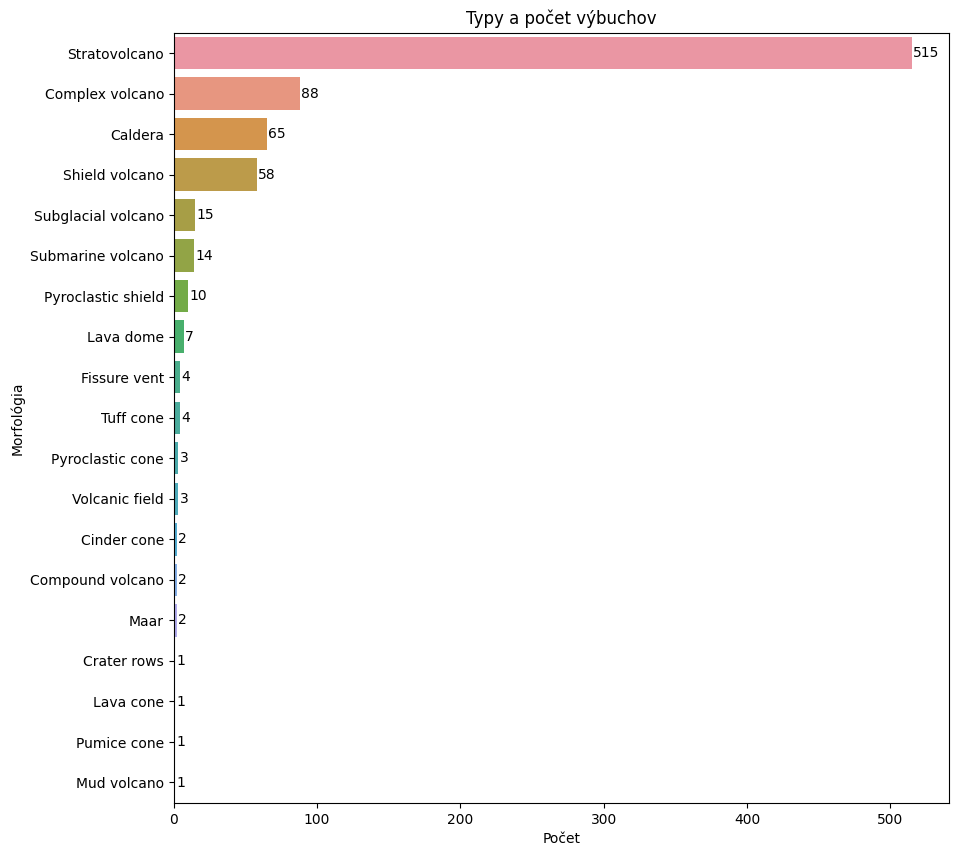

In [ ]:
amount = pd.DataFrame(volEvents.copy(deep=True)['morphology'].value_counts())
figure, axes = plt.subplots(figsize=(10, 10))
try:
  ax = sns.barplot(data=amount, y=amount.index, x='count')
except:
  ax = sns.barplot(data=amount, y=amount.index, x='morphology')
# ax.bar_label(ax.containers[0],)
height = 0
for i, rect in enumerate(axes.patches):
    try:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{amount["morphology"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1
    except KeyError:
        axes.text(rect.get_x() + rect.get_width() + 1, height, f'{amount["count"][i]:.0f}',
                  ha='left', va='center', fontsize=10)
        height += 1

ax.set_xlabel('Počet')
ax.set_ylabel('Morfológia')
ax.set_title('Typy a počet výbuchov')
pass

Graf ukazuje počet vulkanyckých činností rozdelených podľa morfológie, teda typu vulkánu.

Záver: Najčastejším typom zemetrasenia je suverénne Stratovolcano, za ním nasleduje Complex volcano, Caldera a Shield Volcano.

### **Počet sopečných aktivít vzhľadom na VEI index**
V tomto pozorovaní sa snažíme zistiť, či vieme o nejakom VEI (Index vulkanickej aktivity) tvrdiť, že sa vyskytuje najčastejšie.


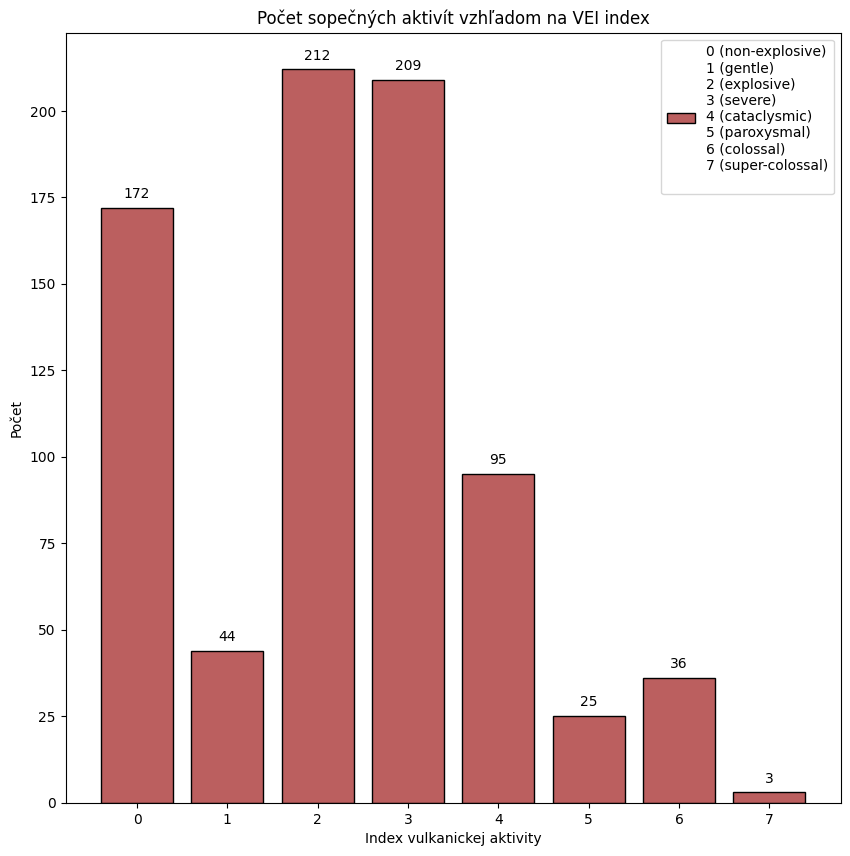

In [ ]:
amount_VEI = volEvents.copy(deep=True)
amount_VEI.sort_values(by='explosivity_index_VEI', inplace=True)
amount_VEI['explosivity_index_VEI'] = amount_VEI['explosivity_index_VEI'].astype(str)
VEI_index ={6: 'colossal', 7: 'super-colossal', 5: 'paroxysmal',  0: 'non-explosive',  4:'cataclysmic',  3: 'severe',  2: 'explosive',  1: 'gentle'}
legend = ''.join([f'{i} ({VEI_index[i]})\n' for i in range(8)])
figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=amount_VEI, x='explosivity_index_VEI', label=legend, color='brown', shrink=0.8)
ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Počet')
ax.set_title('Počet sopečných aktivít vzhľadom na VEI index')


for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 5),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)
plt.legend()

Graf ukazuje počet zemetrasení rozdelených podľa veľosti VEI (volcanic explosivity index).

Záver: Najčastejšie sa vyskytuje VEI index 2. Priama (lineárna závislosť) je úplne vylúčená, výskyt vsopečných aktivít sa zdá byť úplne náhodný.

### **Rozsahy VEI indexov vzhľadom na morfológiu**

VEI je skratka pre Index vulkanickej aktivity, ktorý sa používa na meranie explozivity a intenzity vulkanických erupcií. Index je založený na viacerých faktoroch, ako je objem vylúčenej sopečnej trosky a kamenných fragmentov, výška erupčného oblaku a trvanie erupcie. Škála VEI sa pohybuje od 0 do 8.

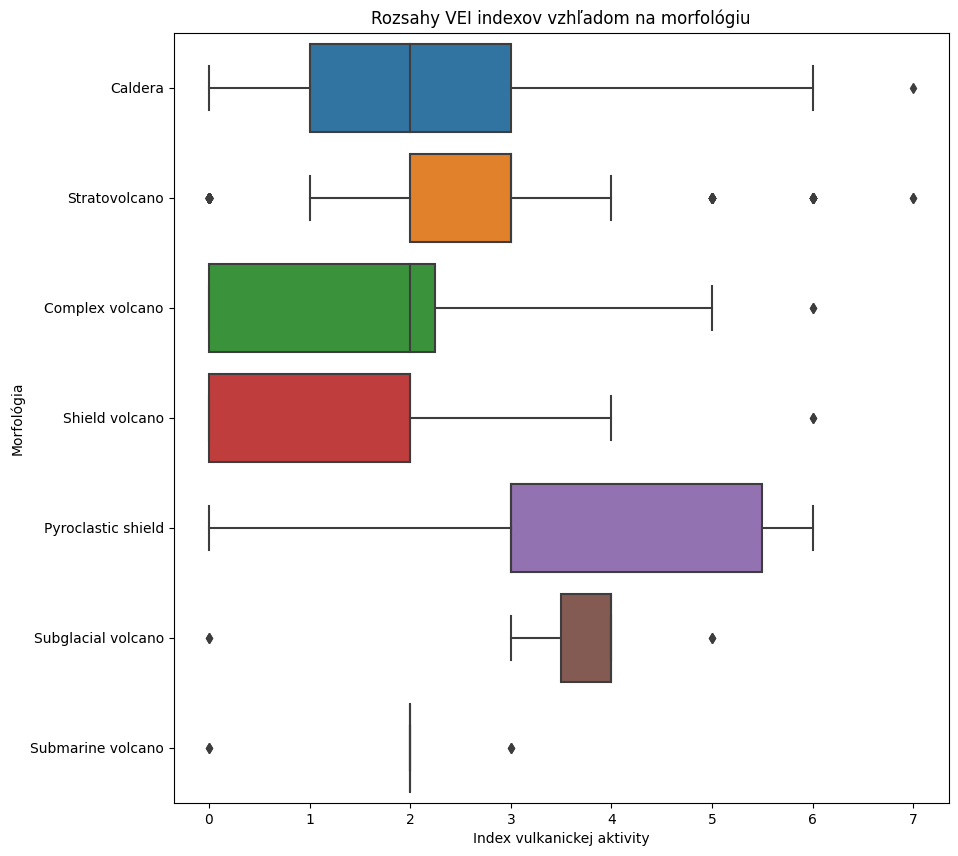

In [ ]:
VEI_range = volEvents.copy(deep=True)
try:
  to_display = amount.query('`count` >= 10').index
except:
  to_display = amount.query('`morphology` >= 10').index

VEI_range = VEI_range.query("`morphology` in @to_display")
figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(data=VEI_range, y='morphology', x='explosivity_index_VEI')
ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Morfológia')
ax.set_title('Rozsahy VEI indexov vzhľadom na morfológiu')
pass

Záver: Pri niektorých typoch sopiek môžeme tvrdiť s akým maximálnym indexom sa pri nich vieme stretnúť. Pri niektorých však nemáme dostatok dát (málo volcano Events pre daný typ). Pri niektorých ako napríklad Caldera alebo Pyroclastic shield zisťujeme, že rozsah je takmer cez všetky VEI indexy.

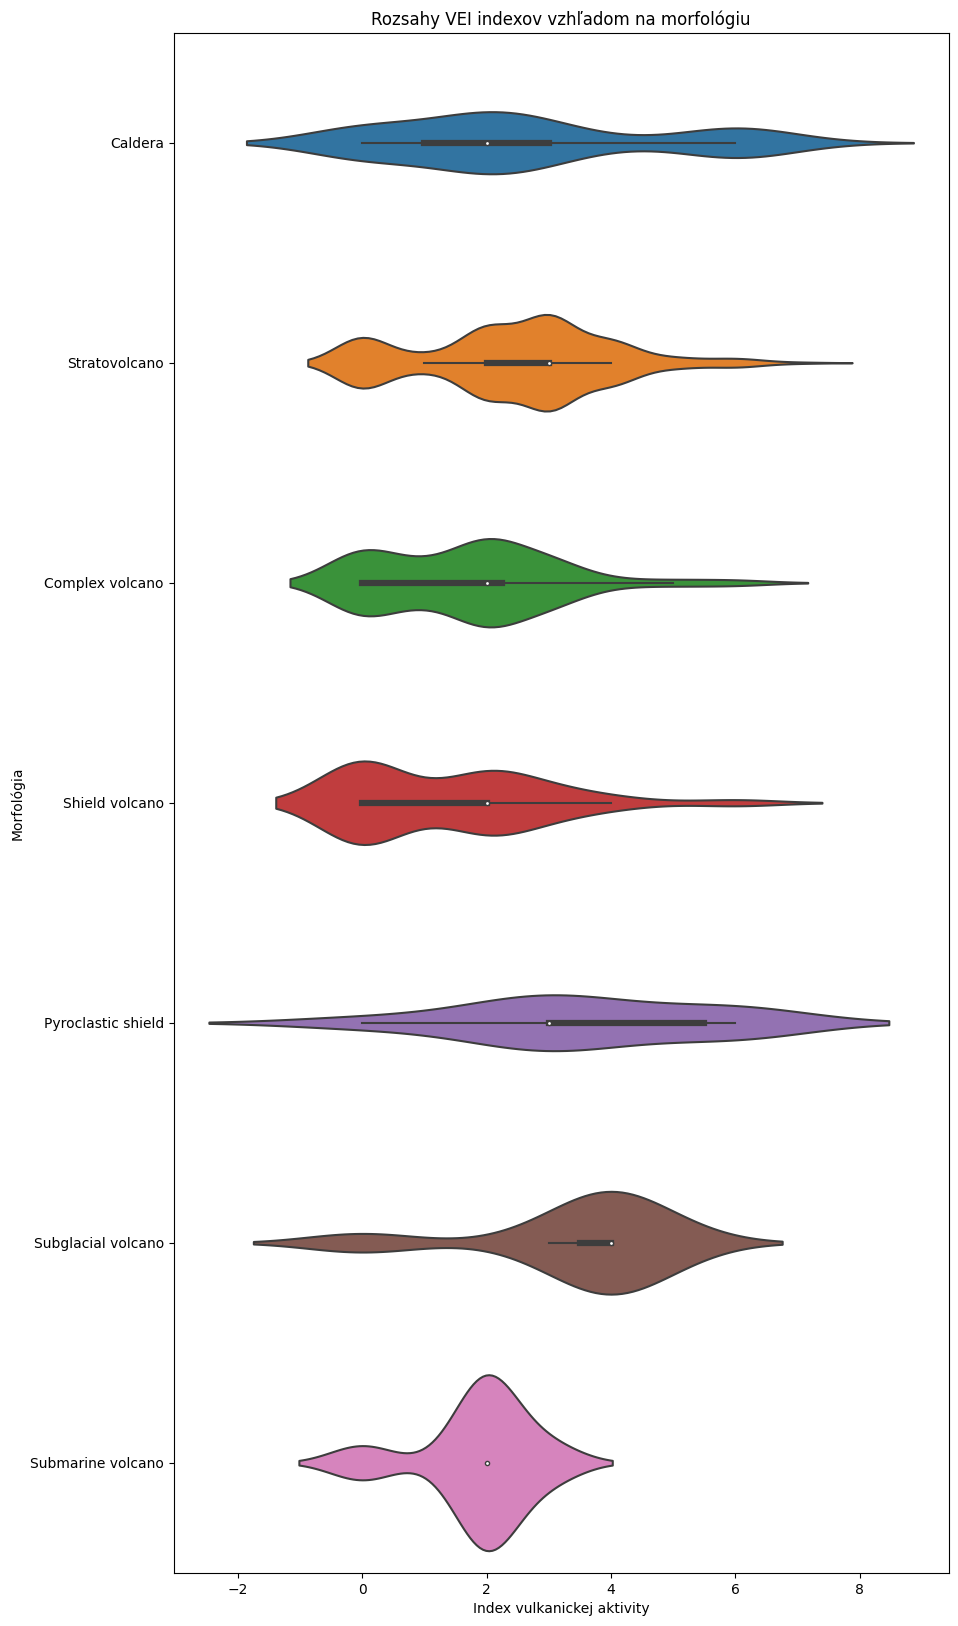

In [ ]:
figure, axes = plt.subplots(figsize=(10, 20))
ax = sns.violinplot(data=VEI_range, y='morphology', x='explosivity_index_VEI')
ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Morfológia')
ax.set_title('Rozsahy VEI indexov vzhľadom na morfológiu')
pass

V tomto pozorovaní sa snažíme zistiť, či vieme o nejakom VEI (Index vulkanickej aktivity) tvrdiť, že sa vyskytuje najčastejšie.

## **4. otázka : Závislosť počtu smrtí od výbuchov**

V tejto sekcii sa zaoberáme závislosťou počtu úmrtí od výbuchov. Grafy a mapy môžeme vidieť nižšie.

### **Distribúcia úmrtí pri vulkanickej aktivite**

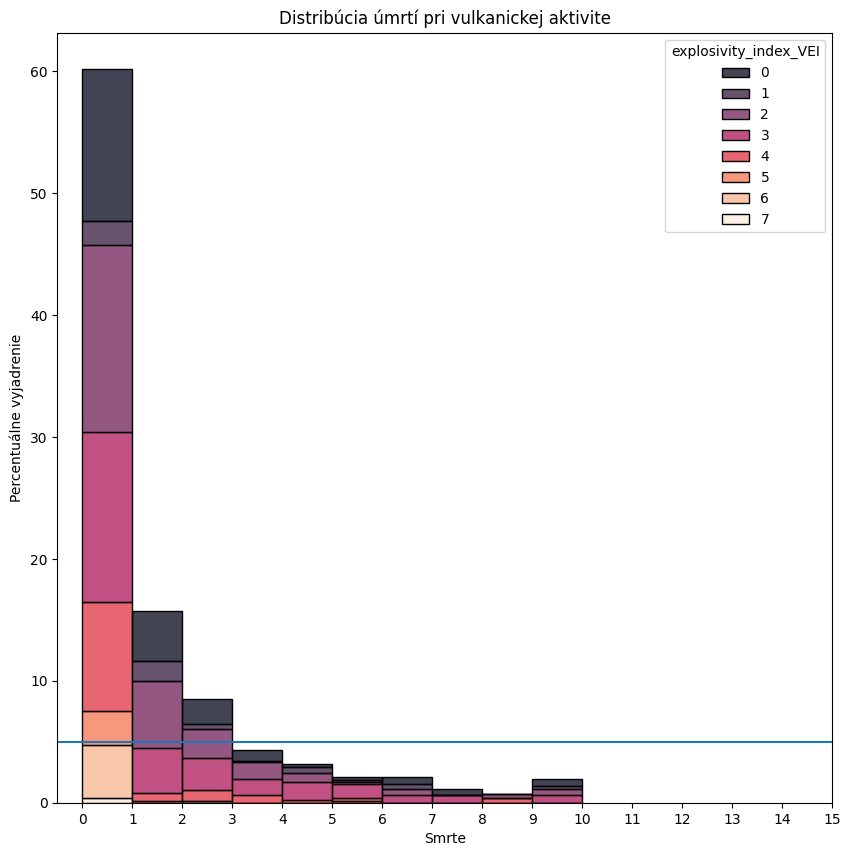

In [ ]:
deaths_distribution = volEvents.copy(deep=True)
figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=deaths_distribution, x='deaths', bins=range(0, 11, 1), hue='explosivity_index_VEI', palette='rocket', multiple='stack', stat='percent')
ax.axhline(y=5)
axes.set_xticks(range(0, 16))
ax.set_xlabel('Smrte')
ax.set_ylabel('Percentuálne vyjadrenie')
ax.set_title('Distribúcia úmrtí pri vulkanickej aktivite')
pass

Graf nám ukazuje percentuálne zastúpenie počtu zemetrasení podľa výšky úmrtnosti a je zafarbený podľa hodnoty VEI.

Záver: Ako prvé si môžeme všimnúť, že obrovské zastúpenie má úmrtnosť 0. Ďalej však nezanedbateľné zastúpenie má úmrtnosť do 4. Modrá priamka určuje hranicu 5tich percent. Môžeme vidieť, že výbuchy nie sú nejaký signifikantný zabijak. Čo sa týka VEI, tak ich pozorujeme celkom rovnomerne.

### **Závislosť úmrtí od VEI (scatterplot)**
V tejto časti sa venujeme tomu, ako sa výbuchy sopiek prejavili na úmrtiach.

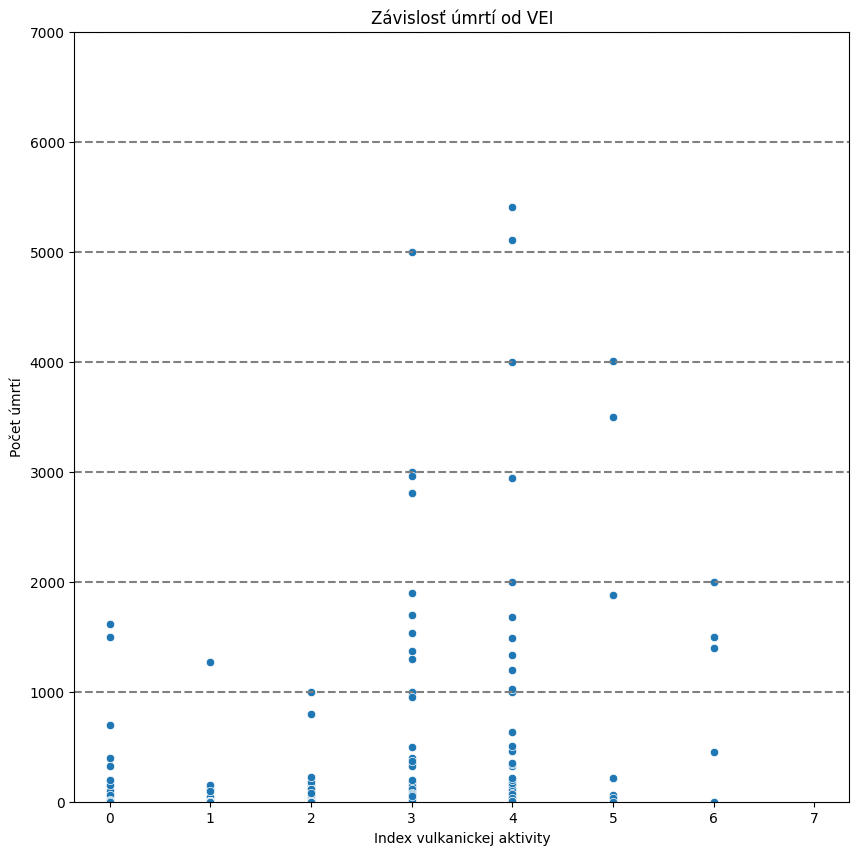

In [ ]:
deaths_box = volEvents.copy(deep=True).query('`deaths` != 0')
deaths_box['explosivity_index_VEI'] = deaths_box['explosivity_index_VEI'].astype(float)
deaths_box['deaths'] = deaths_box['deaths'].astype(float)

figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=deaths_box, x='explosivity_index_VEI', y='deaths')
for i in range(1000, 7001, 1000):
    plt.axhline(y=i, color='grey', linestyle='--')
ax.set_ylim(0, 7000)
ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Počet úmrtí')
ax.set_title('Závislosť úmrtí od VEI')
pass

Graf nám ukazuje závislosť medzi hodnotou VEI a počtu úmrtí

Záver: Vidíme mnoho outlierov a len veľmi málo grúp, a teda sa zdá, že VEI index samotný, hlavne pri hodnotách do 5 VEI s počtom úmrtí nesúvisí.

### **Závislosť úmrtí od VEI (heatmap)**
Ukážeme si rovnaké dáta na heatmape.

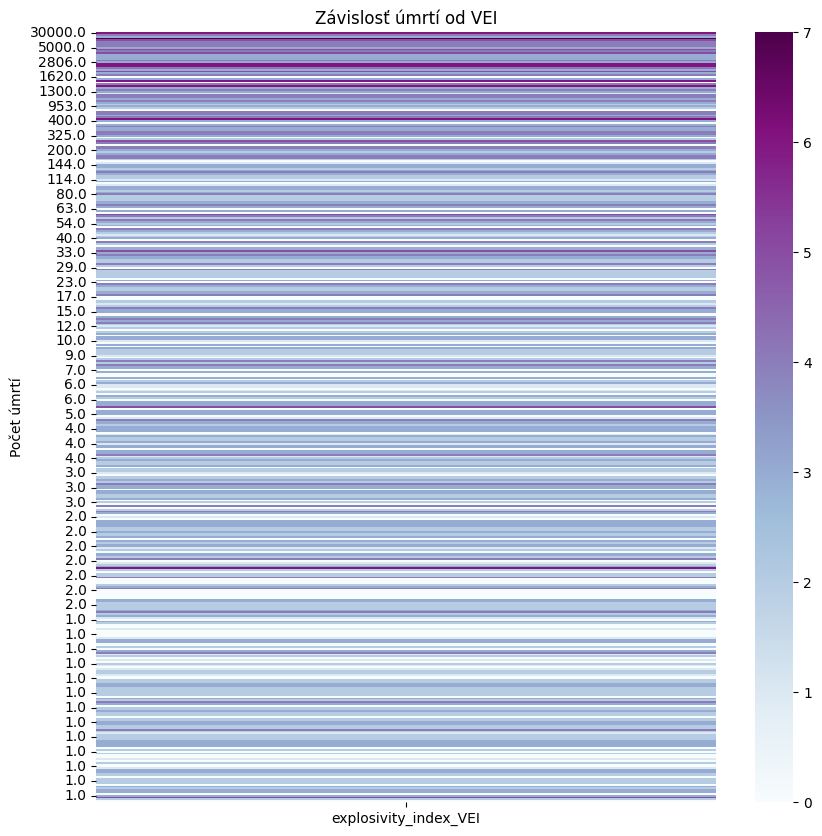

In [ ]:
figure, axes = plt.subplots(figsize=(10, 10))
deaths_hm = (deaths_box.copy(deep=True)[['explosivity_index_VEI', 'deaths']]
             .set_index('deaths')
             .sort_values(by='deaths', ascending=False))
deaths_hm['explosivity_index_VEI'] = deaths_hm['explosivity_index_VEI'].astype(int)
ax = sns.heatmap(data=deaths_hm, cmap='BuPu')
#ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Počet úmrtí')
ax.set_title('Závislosť úmrtí od VEI')
pass

Záver: Heatmapa potvrdzuje zistenie z predošlého boxplotu. Nárast úmrtí sledujeme až pri VEI indexoch väčších ako 5

### **Závislosť úmrtí od VEI pomocou Spearman-Pearson koeficientov**
Dáta ešte zachytíme cez Pearsonov a Spearmanov koeficient.

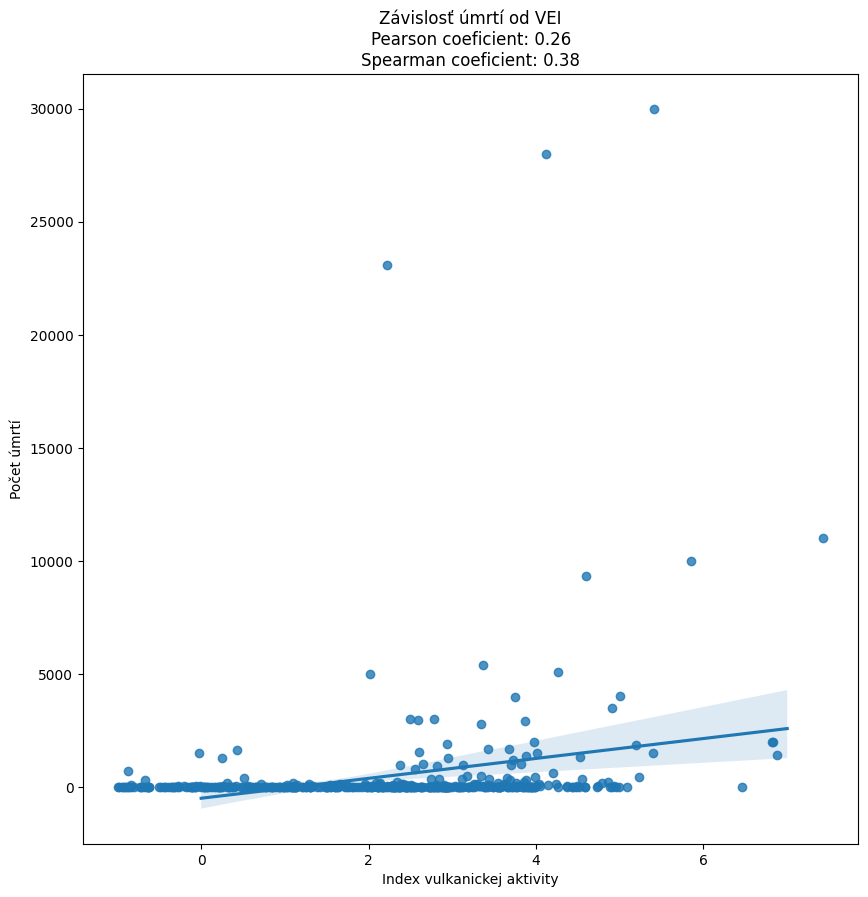

In [ ]:
# display(pd.unique(deaths_box['explosivity_index_VEI']))
deaths_box['explosivity_index_VEI'] = deaths_box['explosivity_index_VEI'].astype(int)
figure, axes = plt.subplots(figsize=(10, 10))
axes = sns.regplot(data=deaths_box, x='explosivity_index_VEI', y='deaths', x_jitter=True)
# nezobrazuje sa to dobre s log
# axes.set(yscale='log')
pearson = round(deaths_box['explosivity_index_VEI'].corr(deaths_box['deaths'], method='pearson'), 2)
spearman = round(deaths_box['explosivity_index_VEI'].corr(deaths_box['deaths'], method='spearman'), 2)
axes.set_title(f'Závislosť úmrtí od VEI\nPearson coeficient: {pearson}\nSpearman coeficient: {spearman}')
axes.set_xlabel('Index vulkanickej aktivity')
axes.set_ylabel('Počet úmrtí')
pass

### **Úmrtia a hustota zaľudnenia**

In [ ]:
# countries data
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_areas = countries['geometry'].to_crs({'proj':'cea'}).area  / 1e6
countries['area'] = country_areas
density = (countries['pop_est']
           / countries['area'])
countries['pop_dens'] = density
display(countries.head())

<ipython-input-33-ab3967e441f6>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry          area   pop_dens  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  1.928760e+04  46.141190  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  9.327793e+05  62.185621  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  9.666925e+04   6.240382  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  1.003773e+07   3.744797  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  9.509851e+06  34.515738

### **Mapa úmrtí nad 1000 po roku 1950 vzhľadom na hustotu zaľudnenia**

In [ ]:
v_trigger = volEvents.query('tsunami == True').copy(deep=True)
t_trigger = tsunamiEvents.loc[tsunamiEvents['cause'].str.contains('Volcano'), :].copy(deep=True)

t_trigger = t_trigger.rename(columns={
    'deaths': 't_deaths',
    'geometry': 't_geometry'
})

v_trigger = v_trigger.rename(columns={
    'deaths': 'v_deaths',
    'geometry': 'v_geometry'
})
# merging volEvents and tsunami
merged = v_trigger.loc[:, ['explosivity_index_VEI', 'v_deaths', 'date', 'v_geometry']]
def vol_date_to_year(x):
    if 'BC' in x:
        x = ('-' + x[: x.find('B')]).strip()
    return x
merged['date'] =  merged['date'].apply(vol_date_to_year)
tsunami_to_merge = t_trigger.loc[:, ['date', 't_deaths', 't_geometry', 'source_location', 'source_country']]
def tsunami_date_to_year(x):
    to = list(x[: x.find('/')])
    out = ''
    start = False
    for i in to:
        if not start:
            if i != '0':
                out += i
        else:
            out += 1
    return out
tsunami_to_merge['date'] = tsunami_to_merge['date'].apply(tsunami_date_to_year)
tsunami_to_merge.reset_index(inplace=True, drop=True)
merged.reset_index(inplace=True, drop=True)
merged = merged.merge(tsunami_to_merge, on='date', how='inner')
display(merged)

explosivity_index_VEI  v_deaths  date                  v_geometry  \
0                        3         0    46   POINT (25.39600 36.40400)   
1                        5      3500    79   POINT (14.42600 40.82100)   
2                        0         0   416  POINT (105.42300 -6.10200)   
3                        3         0   766  POINT (130.67000 31.58000)   
4                        0         0  1169   POINT (15.00400 37.73400)   
..                     ...       ...   ...                         ...   
124                      1         0  1983  POINT (123.59000 -8.54000)   
125                      3         4  1994  POINT (152.20300 -4.27100)   
126                      2         0  1996  POINT (159.43000 54.05000)   
127                      0         0  1997  POINT (-62.18000 16.72000)   
128                      3         0  1999  POINT (-62.18000 16.72000)   

                       t_deaths                  t_geometry  \
0                           NaN   POINT (25.39600 36.40400)   
1                           NaN   POINT (14.42600 40.82100)   
2    Many (~101 to 1000 people)  POINT (105.42300 -6.10200)   
3    Many (~101 to 1000 people)  POINT (130.70000 31.60000)   
4                           NaN   POINT (15.00400 37.73400)   
..                          ...                         ...   
124                         NaN  POINT (123.59000 -8.54000)   
125                         NaN  POINT (152.21400 -4.23800)   
126                         NaN  POINT (159.43000 54.05000)   
127                         NaN  POINT (-62.18000 16.72000)   
128                         NaN  POINT (-62.18000 16.72200)   

                   source_location    source_country  
0         THERA ISLAND (SANTORINI)            GREECE  
1                    BAY OF NAPLES             ITALY  
2                     JAVA-S. JAVA         INDONESIA  
3                 N. KAGOSHIMA BAY             JAPAN  
4                    CALABRIAN ARC             ITALY  
..                             ...               ...  
124           LESSER SUNDA ISLANDS         INDONESIA  
125               PAPUA NEW GUINEA  PAPUA NEW GUINEA  
126  KARYMSKOYE, KAMCHATKA, RUSSIA            RUSSIA  
127             WHITE RIVER VALLEY        MONTSERRAT  
128        SOUFRIERE HILLS VOLCANO        MONTSERRAT  

[129 rows x 8 columns]

In [ ]:
# viac ako tisic umrti
deaths = volEvents.copy(deep=True).query("`deaths` > 1000")
deaths['date'] = deaths['date'].apply(vol_date_to_year)
deaths['date'] = deaths['date'].astype(float)
deaths = deaths.query("`date` > 1950")

# deaths['deaths'] = deaths['deaths'].apply(vol_date_to_year).astype(float)
main = px.choropleth( # mapa ktora zobrazuje krajiny tu hustotu
    countries,
    locations=countries['iso_a3'], # prednaska
    color='pop_dens',
    color_continuous_scale='Blues', #paleta
    range_color=(0, 250), #rozsah
    projection='mollweide',
    title='Mapa úmrtí nad 1000 po roku 1950 vzhľadom na hustotu zaľudnenia'
)
fig = px.scatter_geo( # scatter na mape
    deaths,
    lat=deaths.geometry.y,
    lon=deaths.geometry.x,
    hover_name="name",
    hover_data=['explosivity_index_VEI', 'deaths', 'tsunami', 'date', 'morphology'],
    color_discrete_sequence=['red'], # pouzi jednu farbu
    size ='deaths',
    projection="mollweide",
    )
main.add_trace(fig.data[0]) # pridat do main fig z googelu
main.update_layout(width=1800, height=1000)
main.show()

Mapa ukazuje zemetrasenia s počtom úmrtí väčším ako 1000 po roku 1950 pomocou červeńych bodov a hustotu obyvateľstva zafarbením jednotlivých štátov na základe mierky vpravo.

Záver: Môžeme tvrdiť, že erupcie s vysokým počtom úmrtí sa dejú vo vysoko zaľudnených krajinách? Zdá sa, že nie. Pre porovnanie zobrazíme aj erupcie s malým počtom úmrtí.

### **Mapa úmrtí pod 1000 po roku 1950 vzhľadom na hustotu zaľudnenia**

In [ ]:
deaths = volEvents.copy(deep=True).query("`deaths` <= 1000")
deaths['date'] = deaths['date'].apply(vol_date_to_year)
deaths['date'] = deaths['date'].astype(float)
deaths = deaths.query("`date` > 1950")
main = px.choropleth(
    countries,
    locations=countries['iso_a3'],
    color='pop_dens',
    color_continuous_scale='Blues',
    range_color=(0, 250),
    projection='mollweide',
    title='Mapa úmrtí pod 1000 po roku 1950 vzhľadom na hustotu zaľudnenia'
)

fig = px.scatter_geo(
    deaths,
    lat=deaths.geometry.y,
    lon=deaths.geometry.x,
    hover_name="name",
    hover_data=['explosivity_index_VEI', 'deaths', 'tsunami', 'date', 'morphology'],
    # color_continuous_scale='solar',
    # color='explosivity_index_VEI',
    color_discrete_sequence=['#cb0000'],
    size='deaths',
    projection="mollweide",
    )
main.add_trace(fig.data[0])
main.update_layout(width=1800, height=1000)
main.show()

Mapa ukazuje zemetrasenia s počtom úmrtí menším ako 1000 po roku 1950 pomocou červeńych bodov a hustotu obyvateľstva zafarbením jednotlivých štátov na základe mierky vpravo.

Záver: Môžeme vidieť rovnaké sopky v obidvoch mapách, ale diametrálne rozličný počet úmrtí. Dát s menším počtom úmrtí máme viac, ale na Filipínach, v Japonsku jednoznačne
vidieť, že erupcie s malým počtom úmrtí sa v týchto štátoch nachádzajú aj napriek vysokej hustote zaľudnenia. Veľká poznámka: Aby naše dáta o hustote zaľudnenia nestratili relevantnosť,
tak sa pozeráme na sopky od roku 1950

### **Mapa viac ako 1000 úmrtí, menej ako 1000 úmrtí vzhľadom na mestá**

In [ ]:
main = px.choropleth(
    countries, # regiony
    locations=countries['iso_a3'],
    color_discrete_sequence=['#ffffff'],
    projection='mollweide',
    title='Mapa viac ako 1000 úmrtí, menej ako 1000 úmrtí vzhľadom na mestá'
)

cities_to_scatter = cities.copy(deep=True).query("`population` > 50000")
towns = px.scatter_geo(
    cities_to_scatter,
    lat=cities_to_scatter.lat,
    lon=cities_to_scatter.lng,
    hover_name='city',
    hover_data=['country', 'population'],
    projection='mollweide'
)

deaths_volcano = volEvents.copy(deep=True).query("`deaths` > 1000")
deaths = px.scatter_geo(
    deaths_volcano,
    lat=deaths_volcano.geometry.y,
    lon=deaths_volcano.geometry.x,
    hover_name='date',
    hover_data=['deaths'],
    color_discrete_sequence=['#cb0000'],
    size='explosivity_index_VEI',
    projection='mollweide'
)

low_deaths = volEvents.copy(deep=True).query("`deaths` <= 1000 and `deaths` != 0")
low = px.scatter_geo(
    low_deaths,
    lat=low_deaths.geometry.y,
    lon=low_deaths.geometry.x,
    hover_name='date',
    hover_data=['deaths'],
    color_discrete_sequence=['#00FF00'],
    size='explosivity_index_VEI',
    projection='mollweide'
)
main.add_trace(towns.data[0])
main.add_trace(deaths.data[0])
main.add_trace(low.data[0])
main.update_layout(width=1800, height=1000, geo = dict(showlakes=False))
main.show() # hover podla poradia pridanie

## **5. Otázka : Tsunami a ich prejavy**
V piatej otázke sa zameriavame bližšie na tsunami a ich prejavy.

### **Príčiny tsunami a ich distribúcia vzhľadom na počet smrtí**


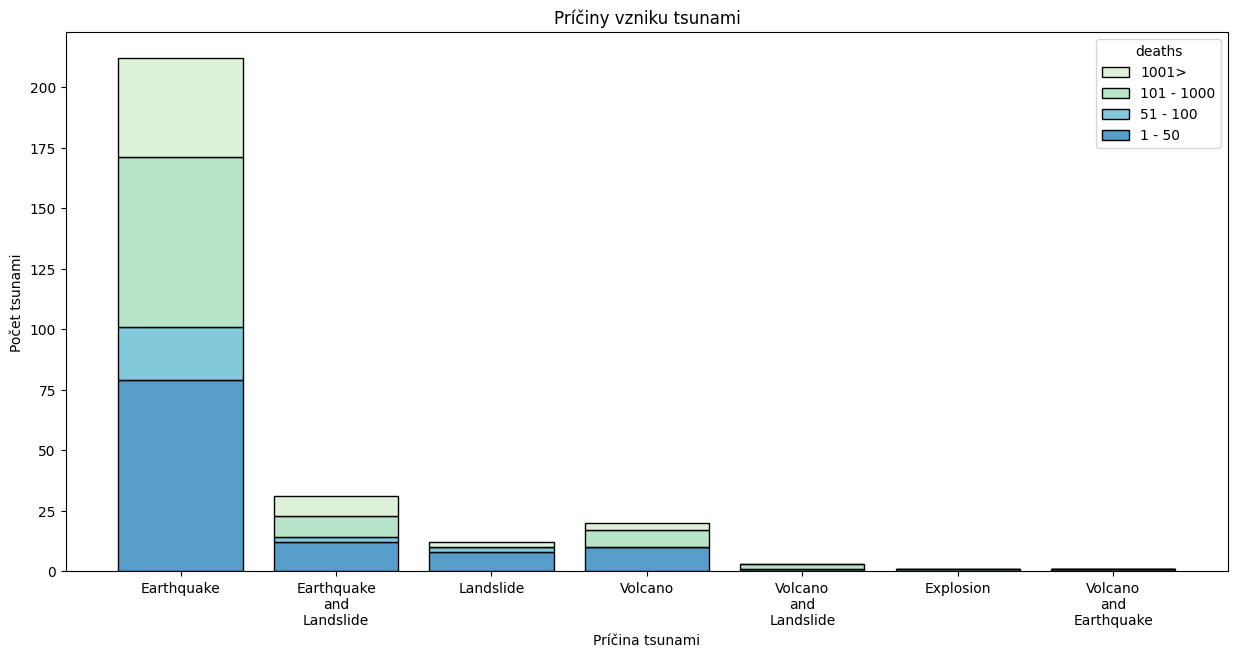

In [ ]:
# lets do deaths compared to causes
tsunamiEvents_d = tsunamiEvents.query("`cause` != 'Unknown' and `deaths`.notnull()").copy(deep=True)
def deaths_parse(value):
    if value is not np.nan:
        index = value.find('(')
        key, value = value[: index].strip(), value[index + 2:]
        ran = ()
        for i in value.split():
             try:
                 ran += int(i),
             except ValueError:
                 pass
        if len(ran) != 2:
            out = (ran[0], 10000)
        else:
            out = (ran[0], ran[1])
        return out
    return value

def rek_deaths_parse(value):
    if value[1] == 10000:
        return f'{value[0]}>'
    return f'{value[0]} - {value[1]}'

tsunamiEvents_d['deaths'] = tsunamiEvents_d['deaths'].apply(deaths_parse)
tsunamiEvents_d.sort_values(by='deaths', inplace=True, ascending=False)
tsunamiEvents_d['deaths'] = tsunamiEvents_d['deaths'].apply(rek_deaths_parse)
# aby sa pomenovania xovej osi neprekryvali
tsunamiEvents_d['cause'] = tsunamiEvents_d['cause'].apply(lambda x: '\n'.join(x.split()))
figure, axes = plt.subplots(figsize=(15, 7))
axes = sns.histplot(data=tsunamiEvents_d, x='cause', hue='deaths', multiple='stack', element='bars', shrink=0.8, palette='GnBu')
axes.set_xlabel('Príčina tsunami')
axes.set_ylabel('Počet tsunami')
axes.set_title('Príčiny vzniku tsunami')
pass

Graf ukazuje počet tsunami rozdelených podľa príčiny vzniku a je zafarbený podľa počtu úmrtí spôsobených tsunami.

Zemetrasenia boli v predošlom grafe najpočetnejšou príčinou vzniku tsunami. Keďže ich bolo cez 200, pripravili sme ešte jeden graf, ktorý sa viac zameriava na menej početné príčiny tsunami.

### **Presnejší histogram s príčinami tsunami**

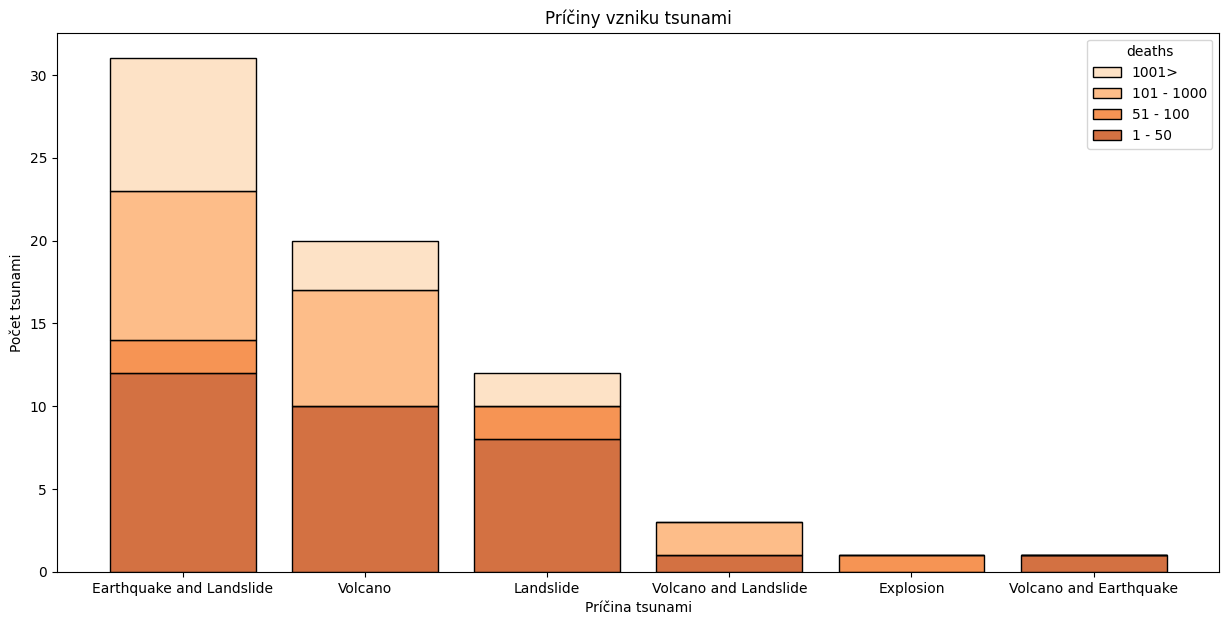

In [ ]:
tsunamiEvents_d2 = tsunamiEvents.query("`cause` != 'Unknown' and `deaths`.notnull()").copy(deep=True)
tsunamiEvents_d2 = tsunamiEvents_d2.query("`cause` not in ('Earthquake')")
tsunamiEvents_d2['deaths'] = tsunamiEvents_d2['deaths'].apply(deaths_parse)
tsunamiEvents_d2.sort_values(by='deaths', inplace=True, ascending=False)
tsunamiEvents_d2['deaths'] = tsunamiEvents_d2['deaths'].apply(rek_deaths_parse)
# tsunamiEvents_d2 = tsunamiEvents_d2.loc[~tsunamiEvents_d2['cause'].str.contains('Earthquake'), :]
figure, axes = plt.subplots(figsize=(15, 7))
axes = sns.histplot(data=tsunamiEvents_d2, x='cause', hue='deaths', multiple='stack', element='bars', shrink=0.8, palette='Oranges')
axes.set_xlabel('Príčina tsunami')
axes.set_ylabel('Počet tsunami')
axes.set_title('Príčiny vzniku tsunami')
pass

Graf ukazuje počet tsunami rozdelených podľa príčiny vzniku a je zafarbený podľa počtu úmrtí spôsobených tsunami. Bez najpočetnejšej príčiny, takže môžeme vidieť porovnanie ostatých hodnôt lepšie.

Môžeme vidieť, že jednotlivé príčiny sa líšia.

### **Distribúcia VEI indexov vzhľadom na tsunami**

In [ ]:
min_voltsunami = volEvents.copy(deep=True).query("`tsunami` == True")
min_voltsunami.sort_values(by='explosivity_index_VEI', inplace=True)
min_voltsunami['explosivity_index_VEI'] = min_voltsunami['explosivity_index_VEI'].astype(str)

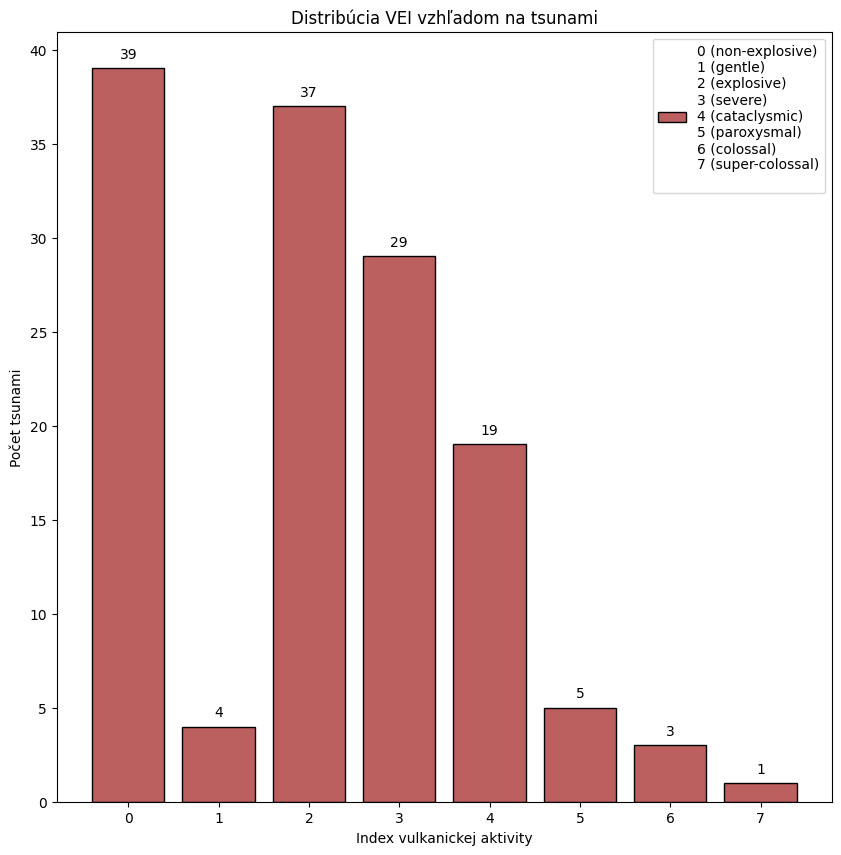

In [ ]:
VEI_index ={6: 'colossal', 7: 'super-colossal', 5: 'paroxysmal',  0: 'non-explosive',  4:'cataclysmic',  3: 'severe',  2: 'explosive',  1: 'gentle'}
legend = ''.join([f'{i} ({VEI_index[i]})\n' for i in range(8)])
figure, axes = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=min_voltsunami, x='explosivity_index_VEI', label=legend, color='brown', shrink=0.8)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 5),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)
plt.legend()
ax.set_xlabel('Index vulkanickej aktivity')
ax.set_ylabel('Počet tsunami')
ax.set_title('Distribúcia VEI vzhľadom na tsunami')
pass

Graf v závislosti hodnôt VEI vulkanických aktivít a počtu spôsobených tsunami týmito aktivitami.

### **Výška tsunami v závislosti od VEI**

In [ ]:
v_trigger = volEvents.query('tsunami == True').copy(deep=True)
t_trigger = tsunamiEvents.loc[tsunamiEvents['cause'].str.contains('Volcano'), :].copy(deep=True)

t_trigger = t_trigger.rename(columns={
    'deaths': 't_deaths',
    'geometry': 't_geometry'
})

v_trigger = v_trigger.rename(columns={
    'deaths': 'v_deaths',
    'geometry': 'v_geometry'
})
# merging volEvents and tsunami
merged = v_trigger.loc[:, ['explosivity_index_VEI', 'v_deaths', 'date', 'v_geometry']]
def vol_date_to_year(x):
    if 'BC' in x:
        x = ('-' + x[: x.find('B')]).strip()
    return x
merged['date'] =  merged['date'].apply(vol_date_to_year)
tsunami_to_merge = t_trigger.loc[:, ['date', 't_deaths', 't_geometry', 'source_location', 'source_country']]
def tsunami_date_to_year(x):
    to = list(x[: x.find('/')])
    out = ''
    start = False
    for i in to:
        if not start:
            if i != '0':
                out += i
        else:
            out += 1
    return out
tsunami_to_merge['date'] = tsunami_to_merge['date'].apply(tsunami_date_to_year)
tsunami_to_merge.reset_index(inplace=True, drop=True)
merged.reset_index(inplace=True, drop=True)
merged = merged.merge(tsunami_to_merge, on='date', how='inner')
display(merged)

explosivity_index_VEI  v_deaths  date                  v_geometry  \
0                        3         0    46   POINT (25.39600 36.40400)   
1                        5      3500    79   POINT (14.42600 40.82100)   
2                        0         0   416  POINT (105.42300 -6.10200)   
3                        3         0   766  POINT (130.67000 31.58000)   
4                        0         0  1169   POINT (15.00400 37.73400)   
..                     ...       ...   ...                         ...   
124                      1         0  1983  POINT (123.59000 -8.54000)   
125                      3         4  1994  POINT (152.20300 -4.27100)   
126                      2         0  1996  POINT (159.43000 54.05000)   
127                      0         0  1997  POINT (-62.18000 16.72000)   
128                      3         0  1999  POINT (-62.18000 16.72000)   

                       t_deaths                  t_geometry  \
0                           NaN   POINT (25.39600 36.40400)   
1                           NaN   POINT (14.42600 40.82100)   
2    Many (~101 to 1000 people)  POINT (105.42300 -6.10200)   
3    Many (~101 to 1000 people)  POINT (130.70000 31.60000)   
4                           NaN   POINT (15.00400 37.73400)   
..                          ...                         ...   
124                         NaN  POINT (123.59000 -8.54000)   
125                         NaN  POINT (152.21400 -4.23800)   
126                         NaN  POINT (159.43000 54.05000)   
127                         NaN  POINT (-62.18000 16.72000)   
128                         NaN  POINT (-62.18000 16.72200)   

                   source_location    source_country  
0         THERA ISLAND (SANTORINI)            GREECE  
1                    BAY OF NAPLES             ITALY  
2                     JAVA-S. JAVA         INDONESIA  
3                 N. KAGOSHIMA BAY             JAPAN  
4                    CALABRIAN ARC             ITALY  
..                             ...               ...  
124           LESSER SUNDA ISLANDS         INDONESIA  
125               PAPUA NEW GUINEA  PAPUA NEW GUINEA  
126  KARYMSKOYE, KAMCHATKA, RUSSIA            RUSSIA  
127             WHITE RIVER VALLEY        MONTSERRAT  
128        SOUFRIERE HILLS VOLCANO        MONTSERRAT  

[129 rows x 8 columns]

In [ ]:
# lets merge tsunami runups
runups_to_be_merged = tsunami_runups.copy(deep=True)
source_country = []
def loc_country(value):
  index = value.find(',')
  loc, country = value[:index].strip(), value[index + 1:].strip()
  source_country.append(country)
  return loc
runups_to_be_merged['source_location'] = runups_to_be_merged['source_location'].apply(loc_country)
runups_to_be_merged['source_country'] = pd.Series(source_country)
runups_to_be_merged['date'] = runups_to_be_merged['date'].apply(tsunami_date_to_year)
runups_to_be_merged.set_index(['source_country', 'date'], inplace=True)


In [ ]:
runups_to_be_merged = runups_to_be_merged.reset_index().loc[:, ['geometry', 'source_location', 'source_country', 'date', 'max_height_m']]
merged_runups = merged.copy(deep=True).merge(runups_to_be_merged, on=['source_location', 'source_country', 'date'], how='inner')

display(merged_runups.head())

explosivity_index_VEI  v_deaths date                  v_geometry  \
0                      0         0  416  POINT (105.42300 -6.10200)   
1                      0         0  416  POINT (105.42300 -6.10200)   
2                      0         0  416  POINT (105.42300 -6.10200)   
3                      0         0  416  POINT (105.42300 -6.10200)   
4                      3         0  766  POINT (130.67000 31.58000)   

                     t_deaths                  t_geometry   source_location  \
0  Many (~101 to 1000 people)  POINT (105.42300 -6.10200)      JAVA-S. JAVA   
1  Many (~101 to 1000 people)  POINT (105.42300 -6.10200)      JAVA-S. JAVA   
2  Many (~101 to 1000 people)  POINT (105.42300 -6.10200)      JAVA-S. JAVA   
3  Many (~101 to 1000 people)  POINT (105.42300 -6.10200)      JAVA-S. JAVA   
4  Many (~101 to 1000 people)  POINT (130.70000 31.60000)  N. KAGOSHIMA BAY   

  source_country                    geometry  max_height_m  
0      INDONESIA   POINT (80.20860 13.11440)           NaN  
1      INDONESIA  POINT (105.94000 -6.34200)           NaN  
2      INDONESIA  POINT (105.65130 -5.83680)           NaN  
3      INDONESIA  POINT (106.80000 -6.78000)           NaN  
4          JAPAN  POINT (130.00000 30.00000)           NaN

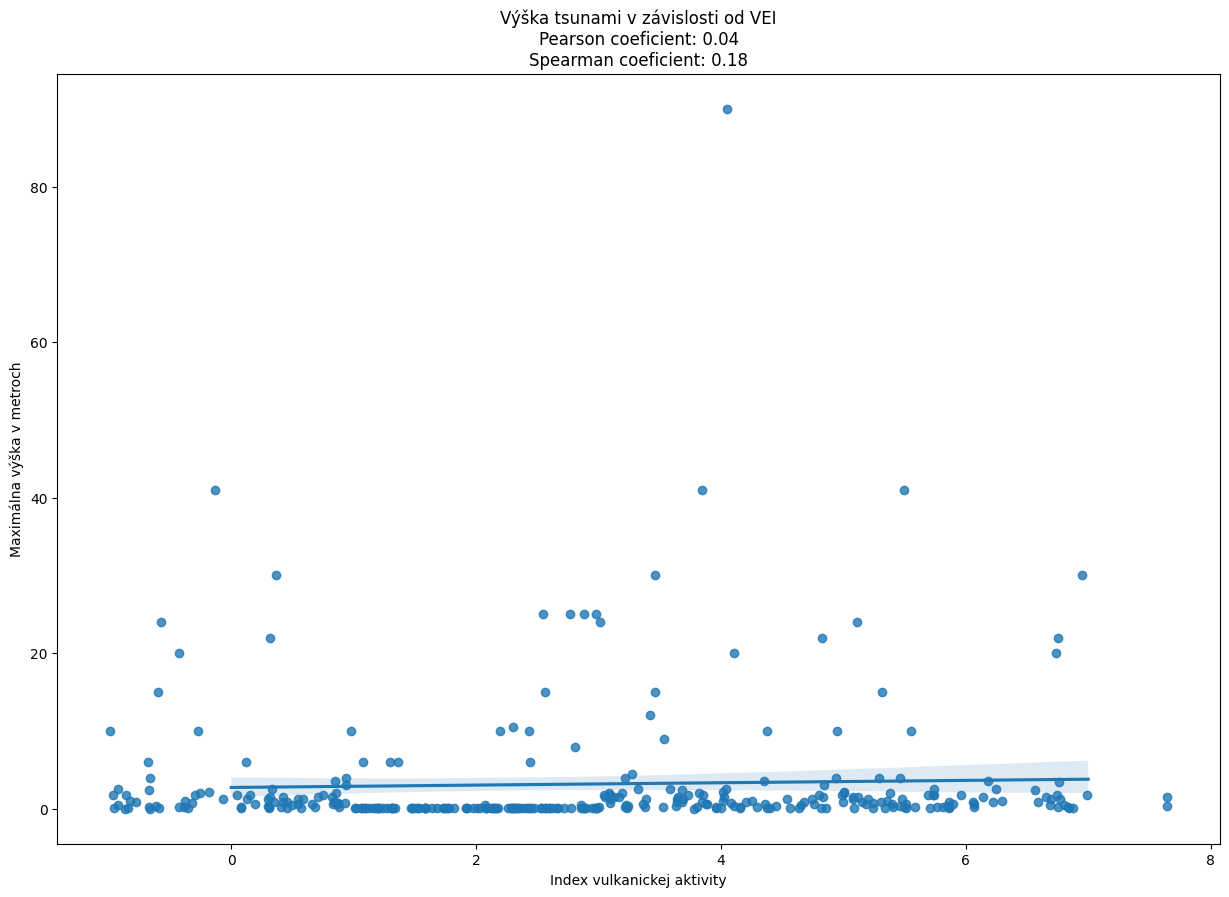

In [ ]:
merged_runups = merged_runups.query("`max_height_m`.notnull()")
figure, axes = plt.subplots(figsize=(15, 10))
axes = sns.regplot(data=merged_runups, x='explosivity_index_VEI', y='max_height_m', x_jitter=True)
# axes.set_ylim(0, 20)
# axes.set(yscale='log')

pearson = round(merged_runups['explosivity_index_VEI'].corr(merged_runups['max_height_m'], method='pearson'), 2)
spearman = round(merged_runups['explosivity_index_VEI'].corr(merged_runups['max_height_m'], method='spearman'), 2)
axes.set_title(f'Výška tsunami v závislosti od VEI\nPearson coeficient: {pearson}\nSpearman coeficient: {spearman}')
axes.set_xlabel('Index vulkanickej aktivity')
axes.set_ylabel('Maximálna výška v metroch')
pass

Graf ukazuje závislošt medzi hodnotou VEI a maximálnou výškou tsunami spôsobenej vulkanickými aktivitami.

Záver: Jednoznačne sa prejavilo, že explosivity index nesúvisí s tým ako sa výsledné tsunami prejaví

### **Magnitúda a výška tsunami**

In [ ]:
# merging tables for visualisation
e_trigger = earthquakes.copy(deep=True)
e_trigger['tsunami'] = (e_trigger['tsunami'].astype(int)
             .map({
    1: True,
    0: False
}))
e_trigger = e_trigger.query("`tsunami` == True")
e_trigger['magnitude'] = e_trigger['magnitude'].astype(float)
e_tsunami = tsunamiEvents.loc[tsunamiEvents['cause'].str.contains('Earthquake'), :].copy(deep=True)

e_tsunami = e_tsunami.rename(columns={
    'deaths': 't_deaths',
    'geometry': 't_geometry'
})

e_trigger = e_trigger.rename(columns={
    'magnitude': 'e_magnitude',
    'deaths': 'e_deaths',
    'geometry': 'e_geometry'
})
# merging earthquakes and tsunami
merged = e_trigger.loc[:, ['e_magnitude', 'e_deaths', 'date', 'e_geometry']]
tsunami_to_merge = e_tsunami.loc[:, ['date', 't_deaths', 't_geometry', 'source_location', 'source_country']]

tsunami_to_merge.reset_index(inplace=True, drop=True)
merged.reset_index(inplace=True, drop=True)

merged = merged.merge(tsunami_to_merge, on='date', how='inner')
# merging tsunami runups
runups_to_be_merged = tsunami_runups.copy(deep=True)
source_country = []
def loc_country(value):
  index = value.find(',')
  loc, country = value[:index].strip(), value[index + 1:].strip()
  source_country.append(country)
  return loc
runups_to_be_merged['source_location'] = runups_to_be_merged['source_location'].apply(loc_country)
runups_to_be_merged['source_country'] = pd.Series(source_country)
runups_to_be_merged.set_index(['source_country', 'date'], inplace=True)
merged.set_index(['source_country', 'date'], inplace=True)

In [ ]:
# mergin to show the whole range
runups_to_be_merged = runups_to_be_merged.reset_index().loc[:, ['geometry', 'source_location', 'source_country', 'date', 'max_height_m']]
merged_runups = merged.merge(runups_to_be_merged, on=['source_location', 'source_country', 'date'])

merged_runups.set_index(['source_country', 'date'], inplace=True)
merged_runups.rename(columns={
    'geometry': 'r_geometry',
}, inplace=True)
merged_runups.reset_index(inplace=True)
merged_runups = merged_runups.query("`e_magnitude`.notnull() and `max_height_m`.notnull()").sort_values(by='e_magnitude')
display(merged_runups)

source_country        date  e_magnitude  \
9250          CHINA  1992/01/05          3.7   
9251          CHINA  1992/01/05          3.7   
9252          CHINA  1992/01/05          3.7   
9253          CHINA  1992/01/05          3.7   
9249          CHINA  1992/01/05          3.7   
...             ...         ...          ...   
5373          CHILE  1960/05/22          9.5   
5374          CHILE  1960/05/22          9.5   
5375          CHILE  1960/05/22          9.5   
5378          CHILE  1960/05/22          9.5   
5695          CHILE  1960/05/22          9.5   

                              e_deaths                   e_geometry  \
9250                               NaN   POINT (108.00000 18.00000)   
9251                               NaN   POINT (108.00000 18.00000)   
9252                               NaN   POINT (108.00000 18.00000)   
9253                               NaN   POINT (108.00000 18.00000)   
9249                               NaN   POINT (108.00000 18.00000)   
...                                ...                          ...   
5373  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5374  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5375  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5378  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5695  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   

                              t_deaths                   t_geometry  \
9250                               NaN   POINT (108.00000 18.00000)   
9251                               NaN   POINT (108.00000 18.00000)   
9252                               NaN   POINT (108.00000 18.00000)   
9253                               NaN   POINT (108.00000 18.00000)   
9249                               NaN   POINT (108.00000 18.00000)   
...                                ...                          ...   
5373  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5374  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5375  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5378  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   
5695  Very Many (~1001 or more people)  POINT (-73.40700 -38.14300)   

      source_location                               r_geometry  max_height_m  
9250  SOUTH CHINA SEA   POINT Z (108.61667 19.10000 179.81022)          0.23  
9251  SOUTH CHINA SEA   POINT Z (110.82000 19.57000 136.37172)          0.17  
9252  SOUTH CHINA SEA   POINT Z (110.28083 20.02592 186.84337)          0.24  
9253  SOUTH CHINA SEA   POINT Z (109.51000 18.23000 510.54501)          0.80  
9249  SOUTH CHINA SEA   POINT Z (109.11000 21.02500 193.82003)          0.25  
...               ...                                      ...           ...  
5373   SOUTHERN CHILE  POINT Z (140.45000 35.51700 1204.11998)          3.00  
5374   SOUTHERN CHILE   POINT Z (139.82500 34.91890 688.78455)          1.21  
5375   SOUTHERN CHILE   POINT Z (139.81700 34.91700 723.45567)          1.30  
5378   SOUTHERN CHILE  POINT Z (140.40000 35.25000 1204.11998)          3.00  
5695   SOUTHERN CHILE  POINT Z (141.08300 38.30000 1112.60500)          2.60  

[20141 rows x 10 columns]

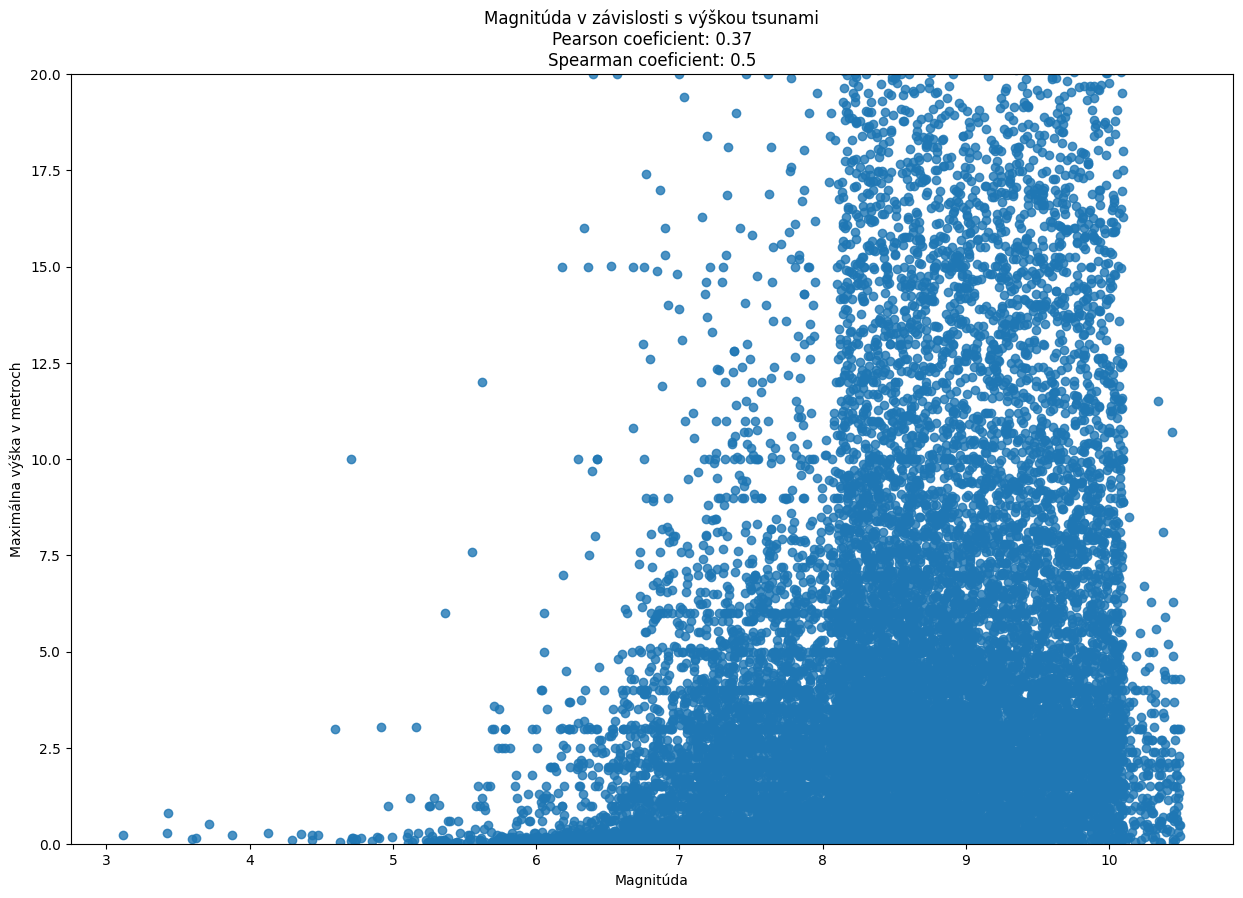

In [ ]:
figure, axes = plt.subplots(figsize=(15, 10))
axes = sns.regplot(data=merged_runups, x='e_magnitude', y='max_height_m', x_jitter=True)
axes.set_ylim(0, 20)
# axes.set(yscale='log')

pearson = round(merged_runups['e_magnitude'].corr(merged_runups['max_height_m'], method='pearson'), 2)
spearman = round(merged_runups['e_magnitude'].corr(merged_runups['max_height_m'], method='spearman'), 2)
axes.set_title(f'Magnitúda v závislosti s výškou tsunami\nPearson coeficient: {pearson}\nSpearman coeficient: {spearman}')
axes.set_xlabel('Magnitúda')
axes.set_ylabel('Maximálna výška v metroch')
pass

Graf v závislosti veľkosti magnitúdy zemetrasenia a maximaĺnej výšky spôsobenej tsunami zemetraseniami.